In [48]:
# Step 1: Imports and global settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import requests
from io import BytesIO

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

url = 'https://raw.githubusercontent.com/GirottoLLS/Social-Media-and-Academic-Impact/refs/heads/main/Data/Students%20Social%20Media%20Addiction.csv'
response = requests.get(url)

In [13]:
# Step 2: Load and preprocess data

# Load dataset, drop unnecessary columns, and rescale hours
df = pd.read_csv(url)
df.drop(columns=['Country'], errors='ignore', inplace=True)
df['SleepHours'] = df['Sleep_Hours_Per_Night'] / 10
df['DailyUsageHours'] = df['Avg_Daily_Usage_Hours'] / 10
df.drop(columns=['Sleep_Hours_Per_Night', 'Avg_Daily_Usage_Hours'], inplace=True)

# Quick data overview
print("--> Data Info:")
df.info()
print("\n--> Descriptive stats for numerical columns:")
df.select_dtypes(include=[np.number]).describe().T

--> Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    705 non-null    int64  
 1   Age                           705 non-null    int64  
 2   Gender                        705 non-null    object 
 3   Academic_Level                705 non-null    object 
 4   Most_Used_Platform            705 non-null    object 
 5   Affects_Academic_Performance  705 non-null    object 
 6   Mental_Health_Score           705 non-null    int64  
 7   Relationship_Status           705 non-null    object 
 8   Conflicts_Over_Social_Media   705 non-null    int64  
 9   Addicted_Score                705 non-null    int64  
 10  SleepHours                    705 non-null    float64
 11  DailyUsageHours               705 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 

,count,mean,std,min,25%,50%,75%,max
Student_ID,705.0,353.000000,203.660256,1.00,177.00,353.00,529.00,705.00
Age,705.0,20.659574,1.399217,18.00,19.00,21.00,22.00,24.00
Mental_Health_Score,705.0,6.226950,1.105055,4.00,5.00,6.00,7.00,9.00
Conflicts_Over_Social_Media,705.0,2.849645,0.957968,0.00,2.00,3.00,4.00,5.00
Addicted_Score,705.0,6.436879,1.587165,2.00,5.00,7.00,8.00,9.00
SleepHours,705.0,0.686894,0.112685,0.38,0.60,0.69,0.77,0.96
DailyUsageHours,705.0,0.491872,0.125739,0.15,0.41,0.48,0.58,0.85


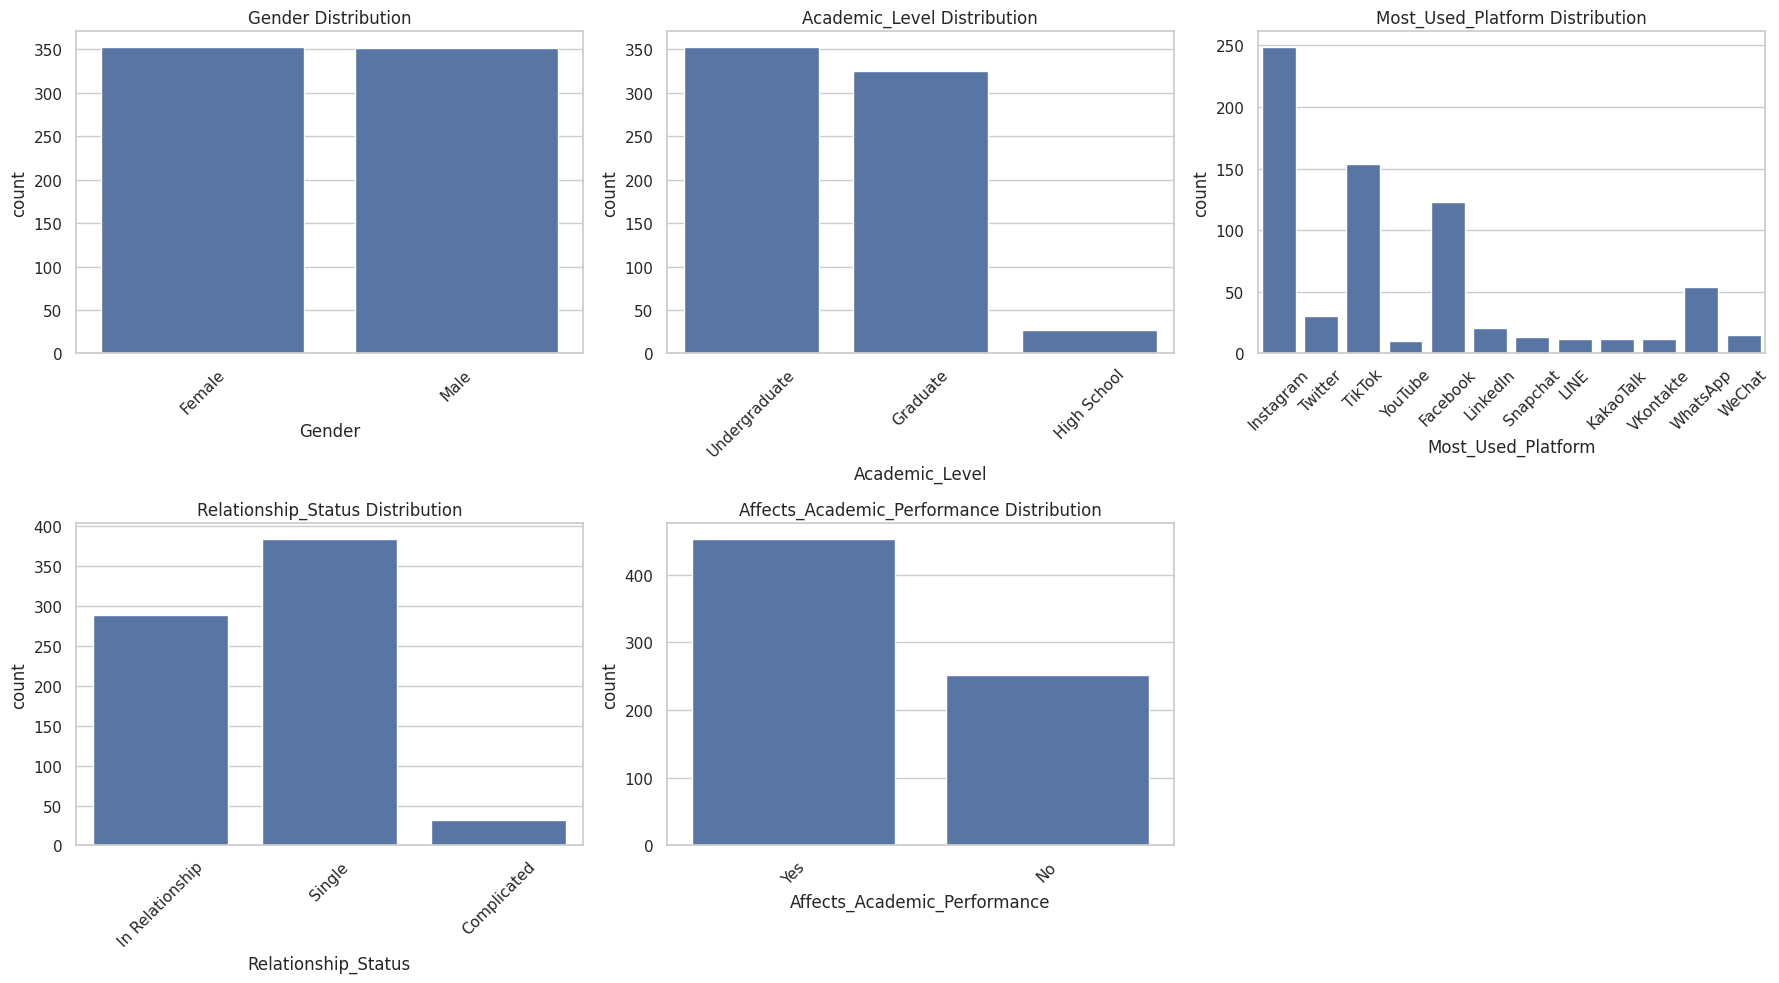

In [23]:
# Step 3: Exploratory plots - categorical variables

categorical = ['Gender', 'Academic_Level', 'Most_Used_Platform', 'Relationship_Status', 'Affects_Academic_Performance']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flatten(), categorical):
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f"{col} Distribution")
    ax.tick_params(axis='x', rotation=45)
fig.delaxes(axes.flatten()[-1])
plt.tight_layout(); plt.show()

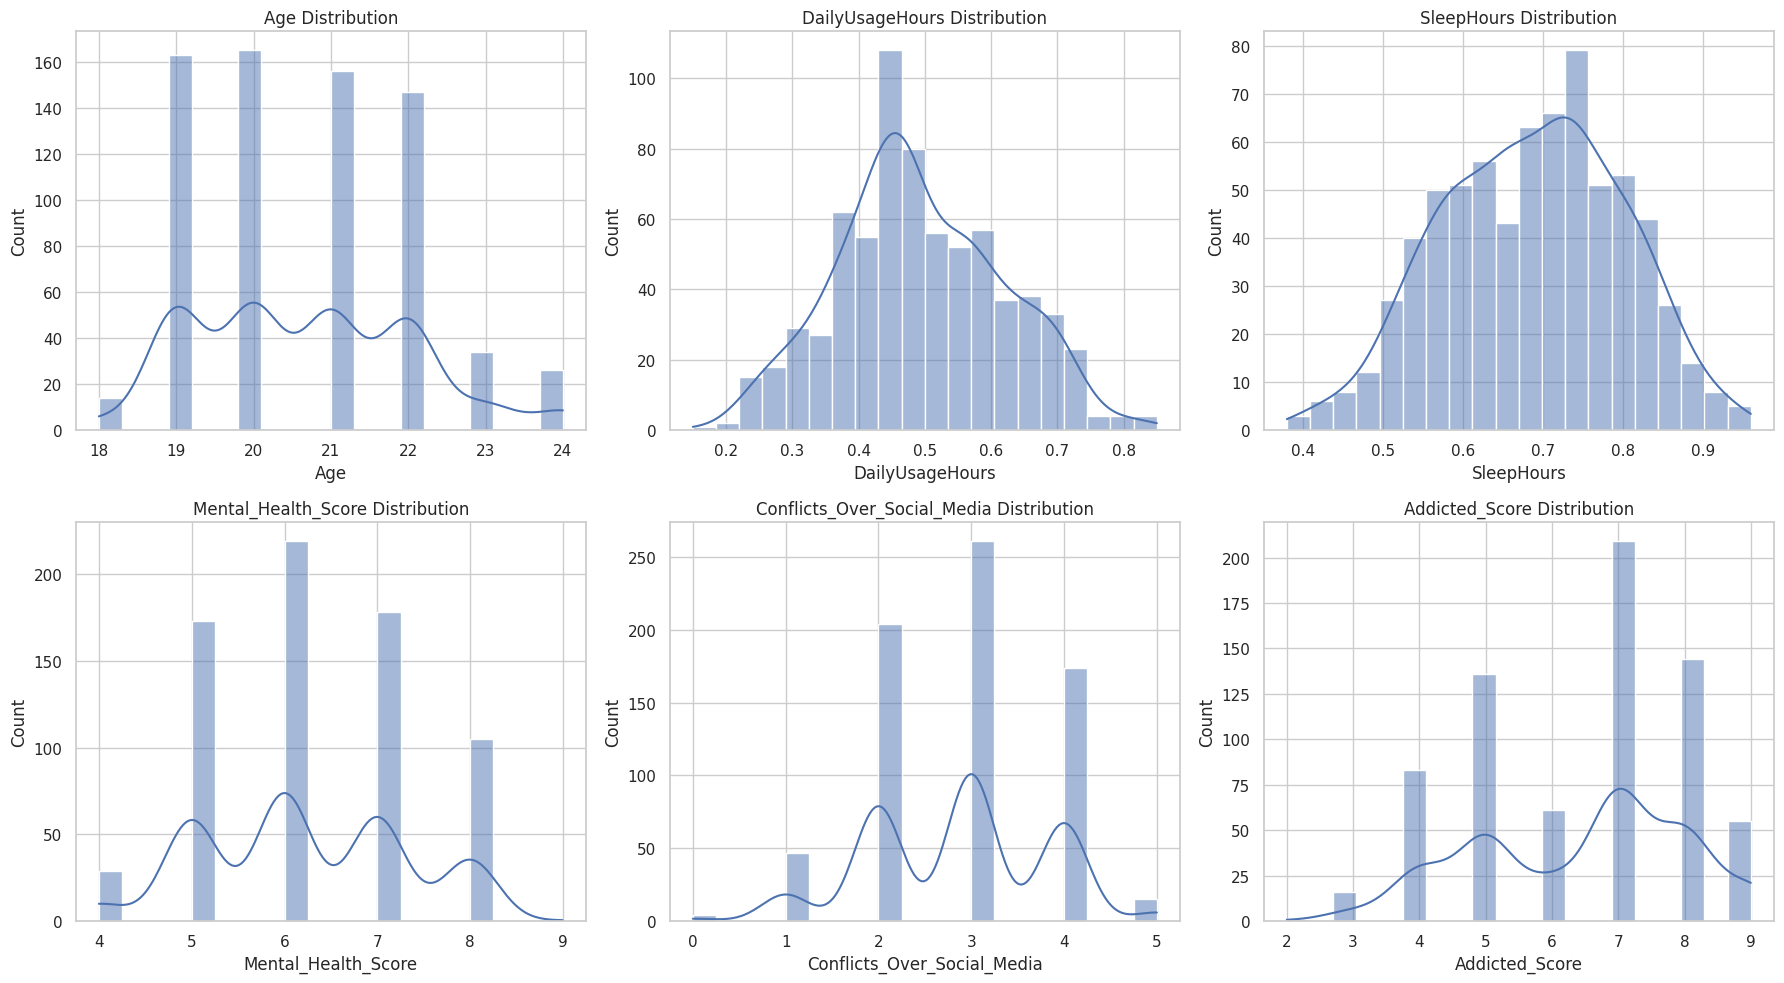

In [24]:
# Step 5: Exploratory plots - numeric variables

numeric = ['Age', 'DailyUsageHours', 'SleepHours', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Addicted_Score']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flatten(), numeric):
    sns.histplot(df[col], kde=True, bins=20, ax=ax)
    ax.set_title(f"{col} Distribution")
plt.tight_layout(); plt.show()

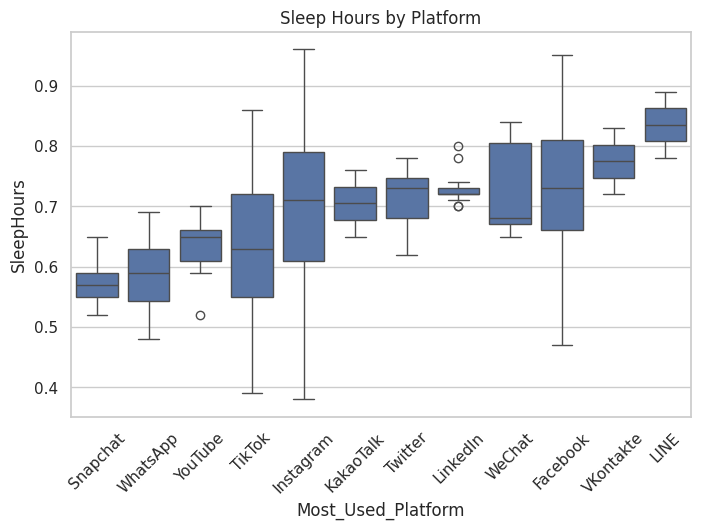

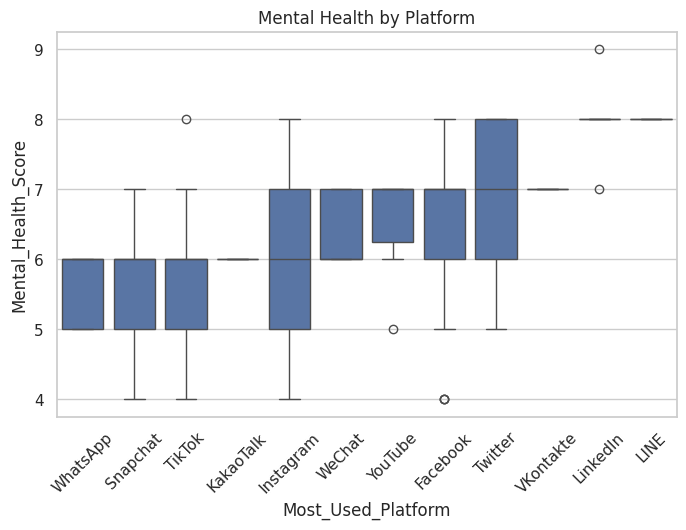

In [27]:
# Step 6: Platform impact on sleep and mental health

# Sleep hours as target variable for Favorite Platform
order_sleep = df.groupby('Most_Used_Platform')['SleepHours'].mean().sort_values().index
sns.boxplot(x='Most_Used_Platform', y='SleepHours', data=df, order=order_sleep)
plt.xticks(rotation=45); plt.title('Sleep Hours by Platform'); plt.show()

# Mental health score as target variable for Favorite Platform
order_mh = df.groupby('Most_Used_Platform')['Mental_Health_Score'].mean().sort_values().index
sns.boxplot(x='Most_Used_Platform', y='Mental_Health_Score', data=df, order=order_mh)
plt.xticks(rotation=45); plt.title('Mental Health by Platform'); plt.show()

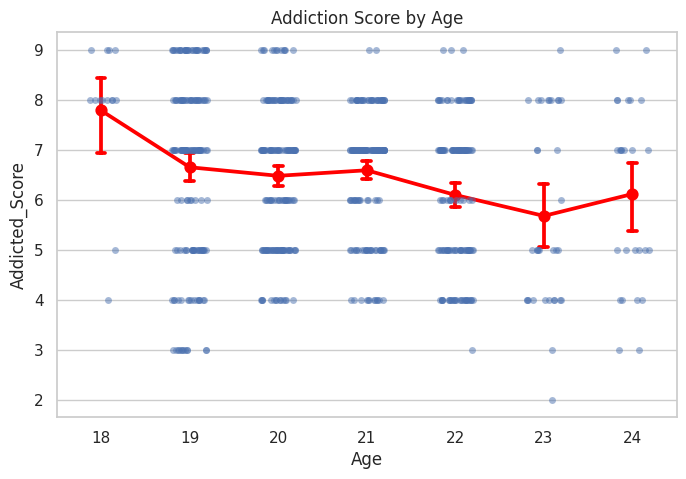

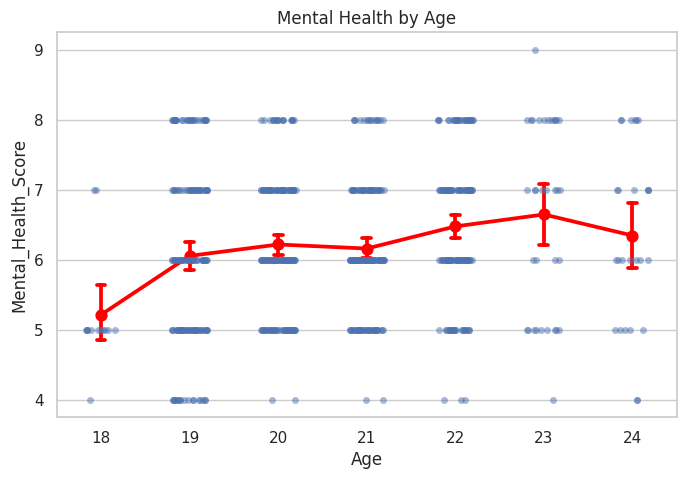

In [28]:
# Step 7: Age vs addiction and mental health

# Addiction score as functon of Age
sns.stripplot(x='Age', y='Addicted_Score', data=df, jitter=0.2, alpha=0.5)
sns.pointplot(x='Age', y='Addicted_Score', data=df, color='red', capsize=0.1)
plt.title('Addiction Score by Age'); plt.show()

# Mental health score as functon of Age
sns.stripplot(x='Age', y='Mental_Health_Score', data=df, jitter=0.2, alpha=0.5)
sns.pointplot(x='Age', y='Mental_Health_Score', data=df, color='red', capsize=0.1)
plt.title('Mental Health by Age'); plt.show()

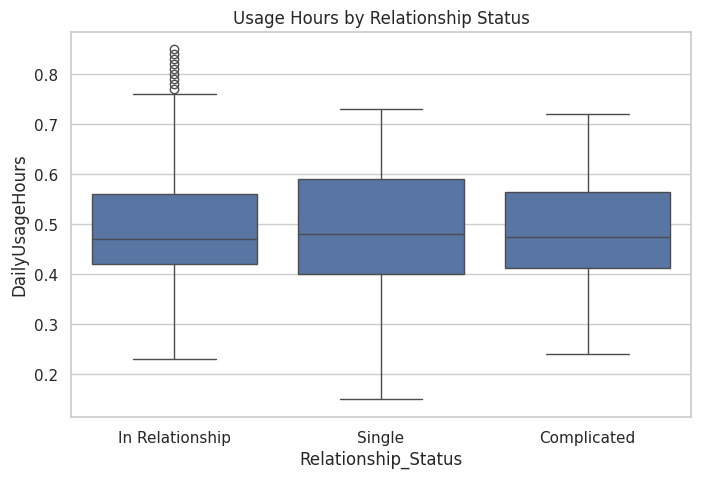

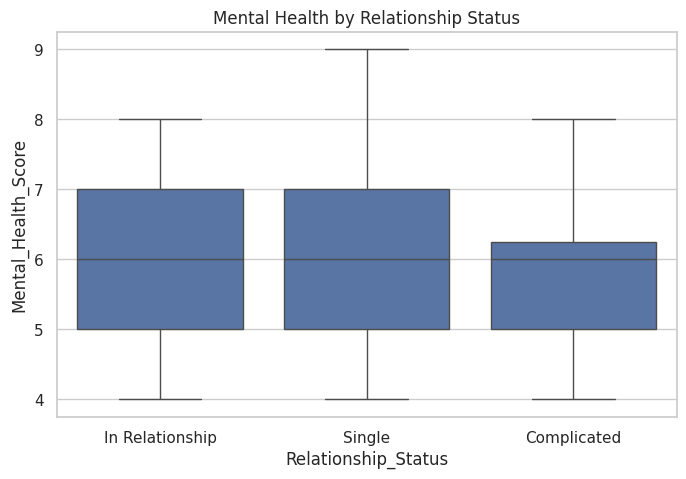

In [29]:
# Step 8: Relationship status impact

# Daily usage hours impact on relationship
sns.boxplot(x='Relationship_Status', y='DailyUsageHours', data=df)
plt.title('Usage Hours by Relationship Status'); plt.show()

# Mental health score impact on relationship
sns.boxplot(x='Relationship_Status', y='Mental_Health_Score', data=df)
plt.title('Mental Health by Relationship Status'); plt.show()

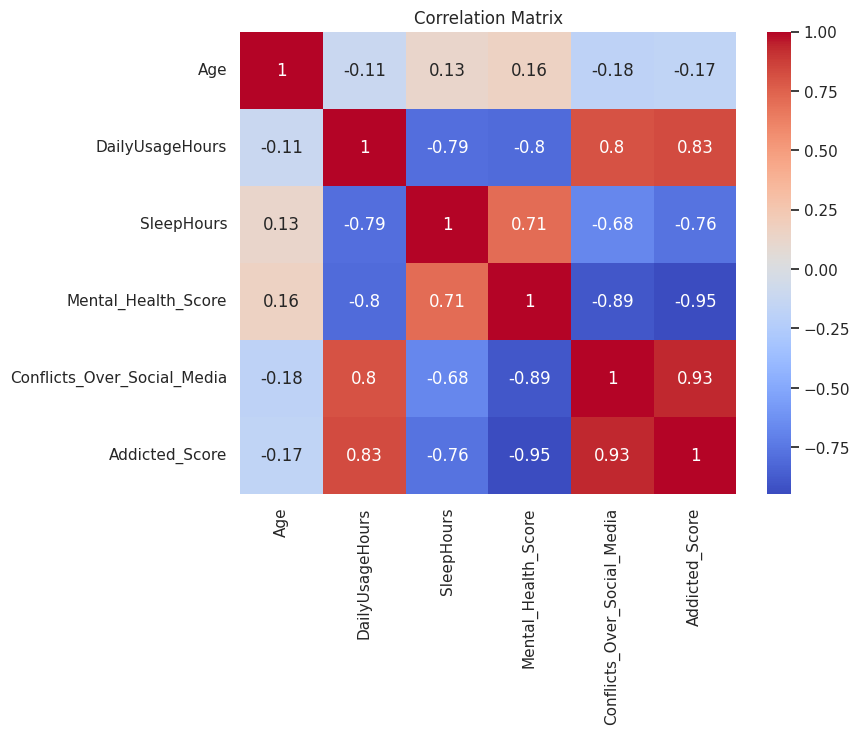

In [30]:
# Step 9: Correlation heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix'); plt.show()

In [31]:
# Step 10: Prepare features and target

y = df['Affects_Academic_Performance'].map({'Yes': 1, 'No': 0})
X = df.drop(columns=['Affects_Academic_Performance', 'Student_ID'], errors='ignore')
X = pd.get_dummies(X, drop_first=True).astype(float)


VIF scores:
 const                                  3087.345451
Age                                       4.195149
Mental_Health_Score                      11.249380
Conflicts_Over_Social_Media               9.366930
Addicted_Score                           24.131174
SleepHours                                4.534549
DailyUsageHours                           6.664878
Gender_Male                               2.186777
Academic_Level_High School                2.410019
Academic_Level_Undergraduate              5.266710
Most_Used_Platform_Instagram              2.530416
Most_Used_Platform_KakaoTalk              1.204106
Most_Used_Platform_LINE                   1.357356
Most_Used_Platform_LinkedIn               1.680670
Most_Used_Platform_Snapchat               1.290830
Most_Used_Platform_TikTok                 2.480174
Most_Used_Platform_Twitter                1.265357
Most_Used_Platform_VKontakte              1.102288
Most_Used_Platform_WeChat                 1.136417
Most_Used_Platfor

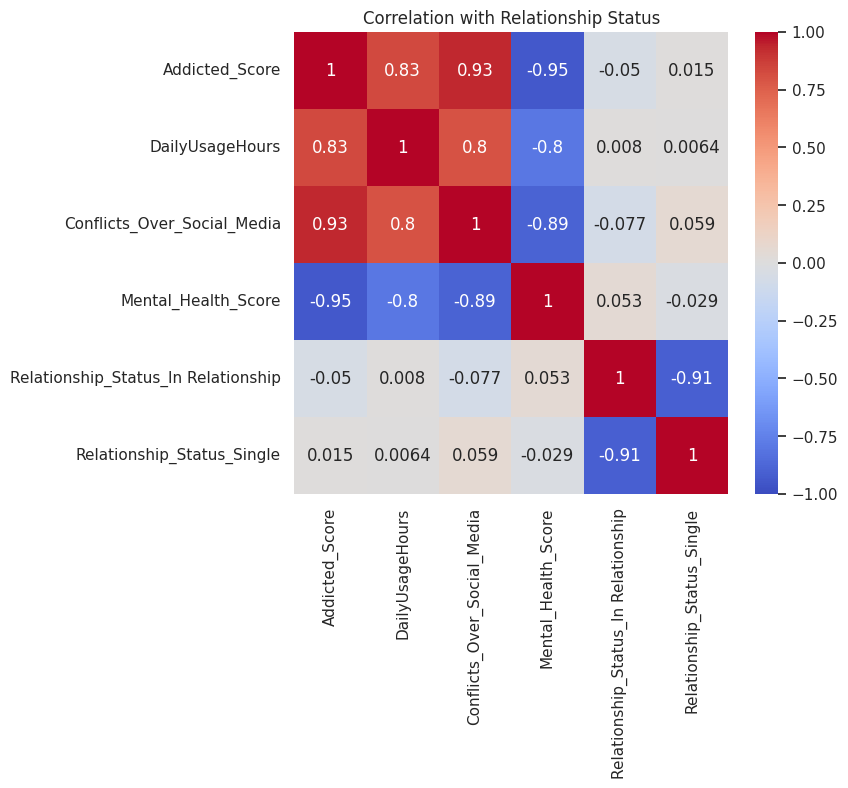

In [32]:
# Step 11: Check multicollinearity with VIF

def compute_vif(df_input):
    vif_df = sm.add_constant(df_input)
    return pd.Series(
        [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])],
        index=vif_df.columns,
        name='VIF')

vif_scores = compute_vif(X)
print("\nVIF scores:\n", vif_scores)

# Multicollinearity heatmap for key features
key_feats = ['Addicted_Score', 'DailyUsageHours', 'Conflicts_Over_Social_Media',
             'Mental_Health_Score', 'Relationship_Status_In Relationship',
             'Relationship_Status_Single']
plt.figure(figsize=(7, 6))
sns.heatmap(X[key_feats].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Relationship Status'); plt.show()

In [34]:
# Step 12: Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
# Step 14: ROC/AUC plotting function
def plot_roc(y_true, y_score, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")
    return roc_auc

In [39]:
# Step 15: Baseline (null) and full logistic regression models

# Null logistic model
X0 = sm.add_constant(pd.DataFrame(np.zeros((len(y_train), 0)), index=y_train.index))
model_null = sm.Logit(y_train, X0).fit(disp=False)
print(f"Null Model AIC: {model_null.aic:.2f}")

# Full logistic model, includes all variables
# An error will be returned here due to high multicolinearity
X1 = sm.add_constant(X_train)
model_full = sm.Logit(y_train, X1).fit(disp=False)
print(f"Full Model AIC: {model_full.aic:.2f}")

Null Model AIC: 737.85


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

In [40]:
# Step 16: LASSO Logistic Regression

pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])

pipeline_lasso.fit(X_train, y_train)
coefs = pd.Series(pipeline_lasso.named_steps['lasso'].coef_[0], index=X_train.columns)
print("\nNon-zero LASSO coefficients:")
print(coefs[coefs.abs() > 1e-6].sort_values(ascending=False))


Non-zero LASSO coefficients:
Conflicts_Over_Social_Media     5.407063
Addicted_Score                  4.042342
Most_Used_Platform_KakaoTalk    0.105981
Relationship_Status_Single      0.061393
Most_Used_Platform_YouTube     -0.079405
dtype: float64


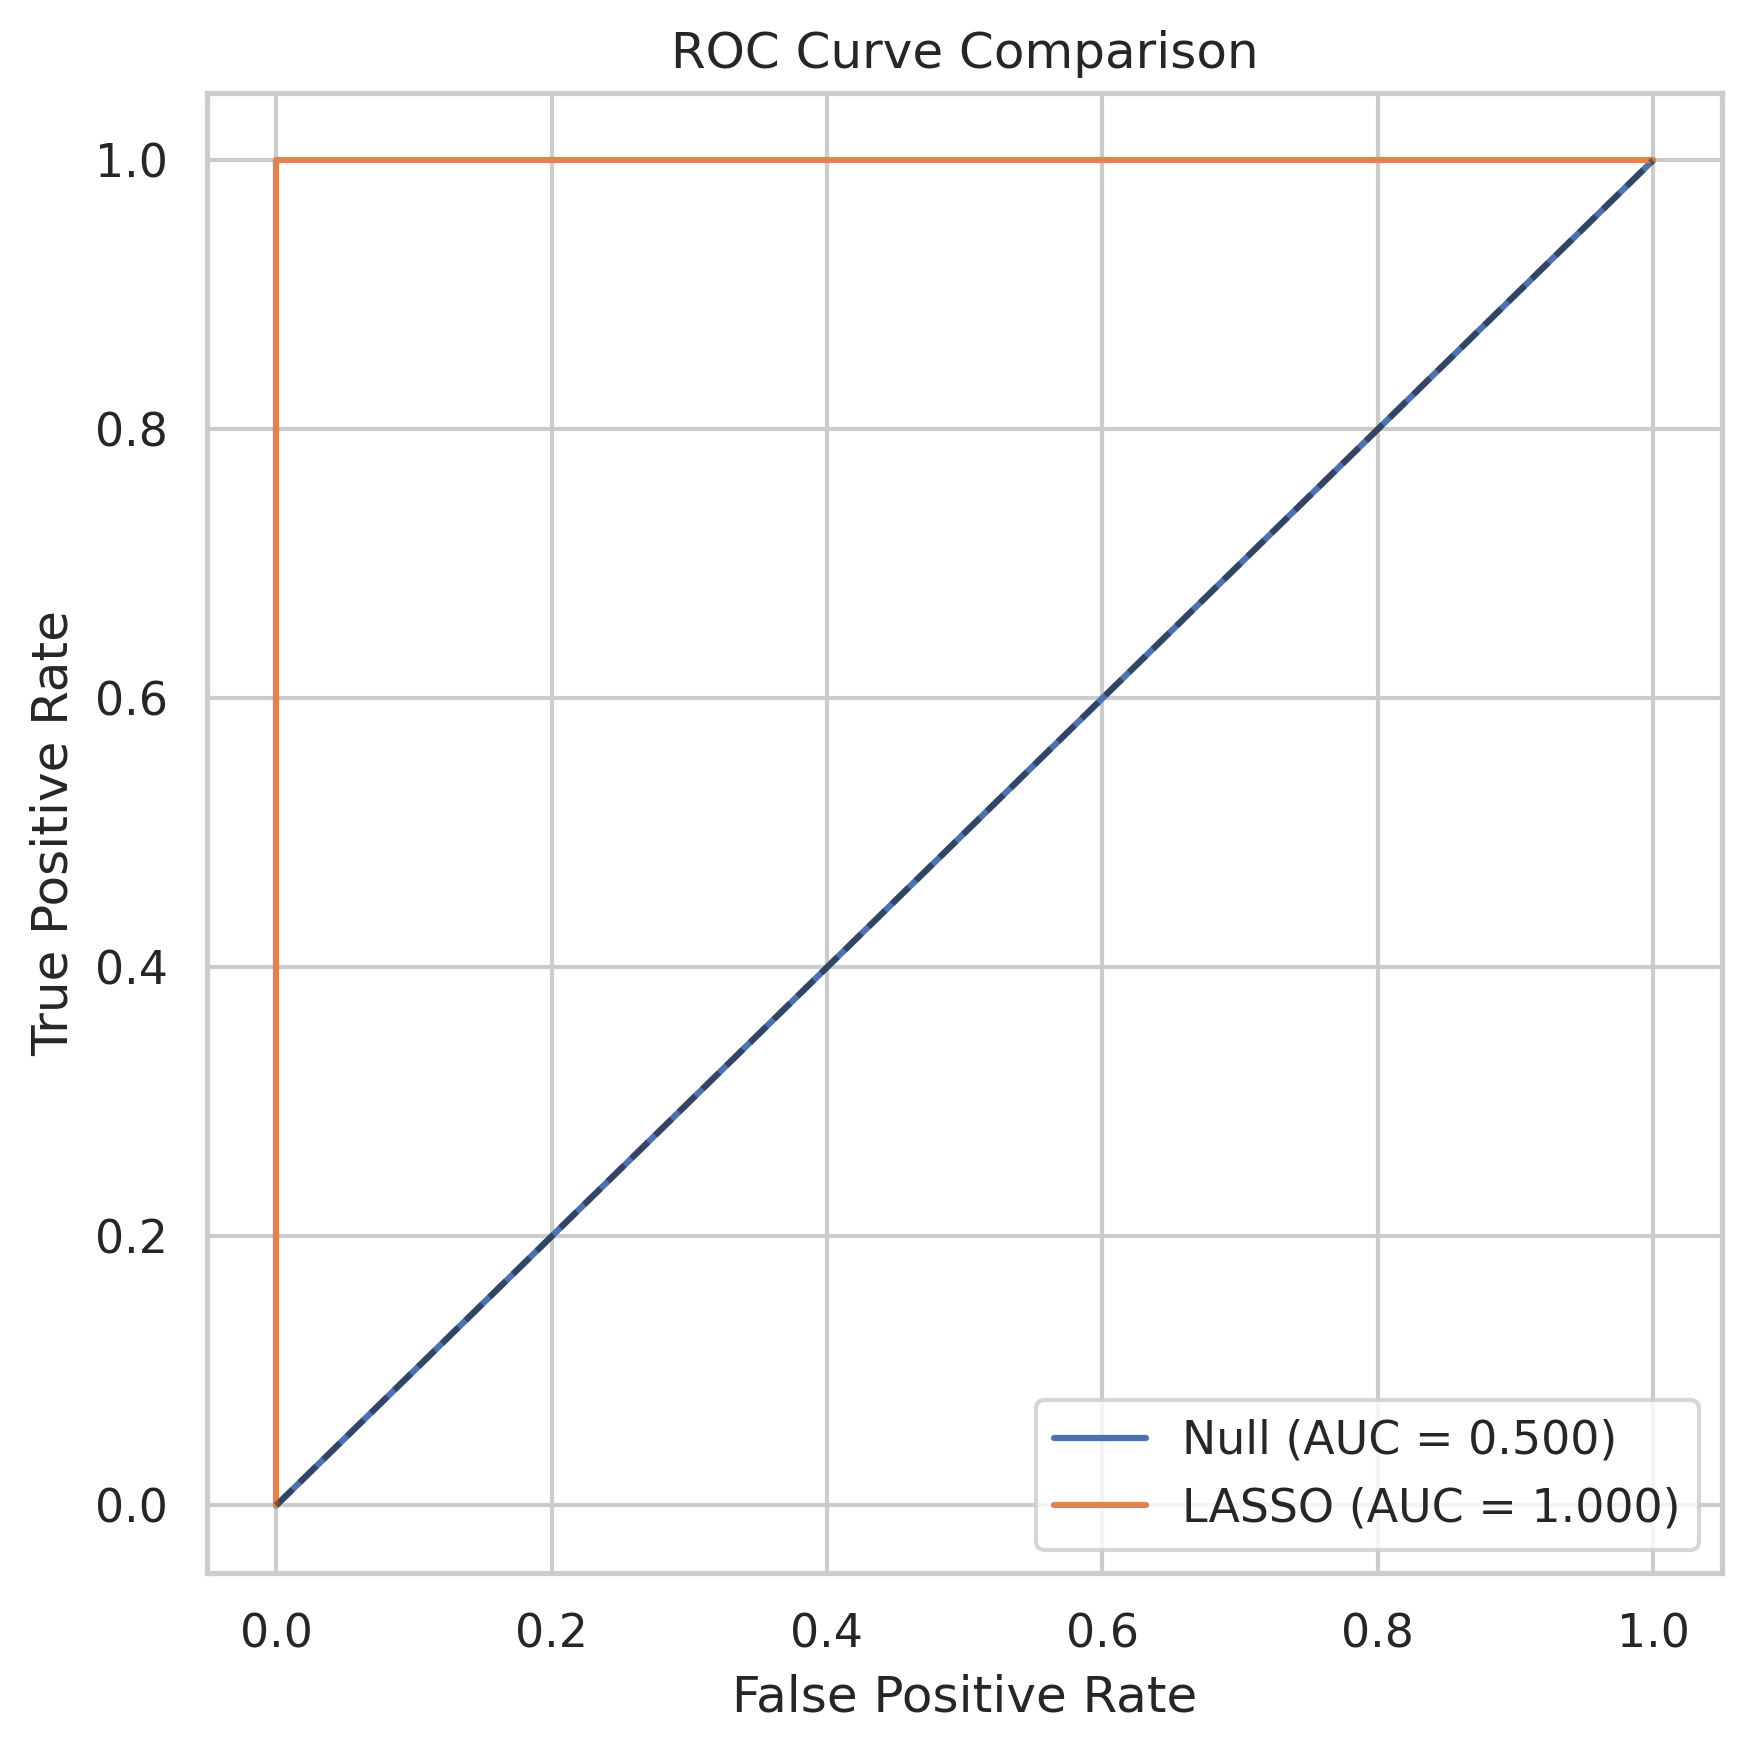

In [49]:
# Step 17: Compare ROC curves

plt.figure(figsize=(6, 6), dpi=300)

# Null
y_null_score = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
auc_null = plot_roc(y_test, y_null_score, label='Null')

# LASSO
y_lasso_score = pipeline_lasso.predict_proba(X_test)[:, 1]
auc_lasso = plot_roc(y_test, y_lasso_score, label='LASSO')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

In [44]:
# Step 18: Confusion matrices and classification reports
print("Confusion Matrix & Report: LASSO")
y_pred = (y_lasso_score >= 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

Confusion Matrix & Report: LASSO
[[50  0]
 [ 0 91]]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



In [45]:
# Step 19: Cross-validated AUC for LASSO

cv_auc = cross_val_score(pipeline_lasso, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC (5-fold): {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

Cross-validated AUC (5-fold): 1.000 ± 0.000


In [46]:
# Step 20: Alternative LASSO variants via cross-validation

def evaluate_variants(X_base, y, variants_dict, cv=15):
    results = {}
    for name, X_var in variants_dict.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])
        scores = cross_val_score(pipeline, X_var, y, cv=cv, scoring='roc_auc')
        results[name] = scores
        print(f"{name} — AUC per fold: {np.round(scores,3)}")
        print(f"{name} — Mean AUC = {scores.mean():.3f} ± {scores.std():.3f}\n")
    return results

variants = {
    'No Addicted_Score': X.drop(columns=['Addicted_Score']),
    'No Conflicts': X.drop(columns=['Conflicts_Over_Social_Media']),
    'No Both': X.drop(columns=['Addicted_Score','Conflicts_Over_Social_Media'])}

evaluate_variants(X, y, variants)

No Addicted_Score — AUC per fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
No Addicted_Score — Mean AUC = 1.000 ± 0.000

No Conflicts — AUC per fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
No Conflicts — Mean AUC = 1.000 ± 0.000

No Both — AUC per fold: [0.992 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.988 0.949
 1.    1.    1.   ]
No Both — Mean AUC = 0.995 ± 0.013



{'No Addicted_Score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'No Conflicts': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'No Both': array([0.99193548, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.98823529, 0.94901961, 1.        , 1.        , 1.        ])}

Variables retained in 'No Both' model:
Most_Used_Platform_TikTok              1.300683
Most_Used_Platform_Instagram           0.940456
Relationship_Status_Single             0.672646
DailyUsageHours                        0.417508
Most_Used_Platform_Snapchat            0.175853
Most_Used_Platform_KakaoTalk           0.134125
Gender_Male                            0.101996
Most_Used_Platform_Twitter             0.055057
Relationship_Status_In Relationship   -0.268211
Most_Used_Platform_VKontakte          -0.284931
Age                                   -0.823745
Academic_Level_Undergraduate          -1.000364
Academic_Level_High School            -1.111288
Mental_Health_Score                   -6.642701
dtype: float64


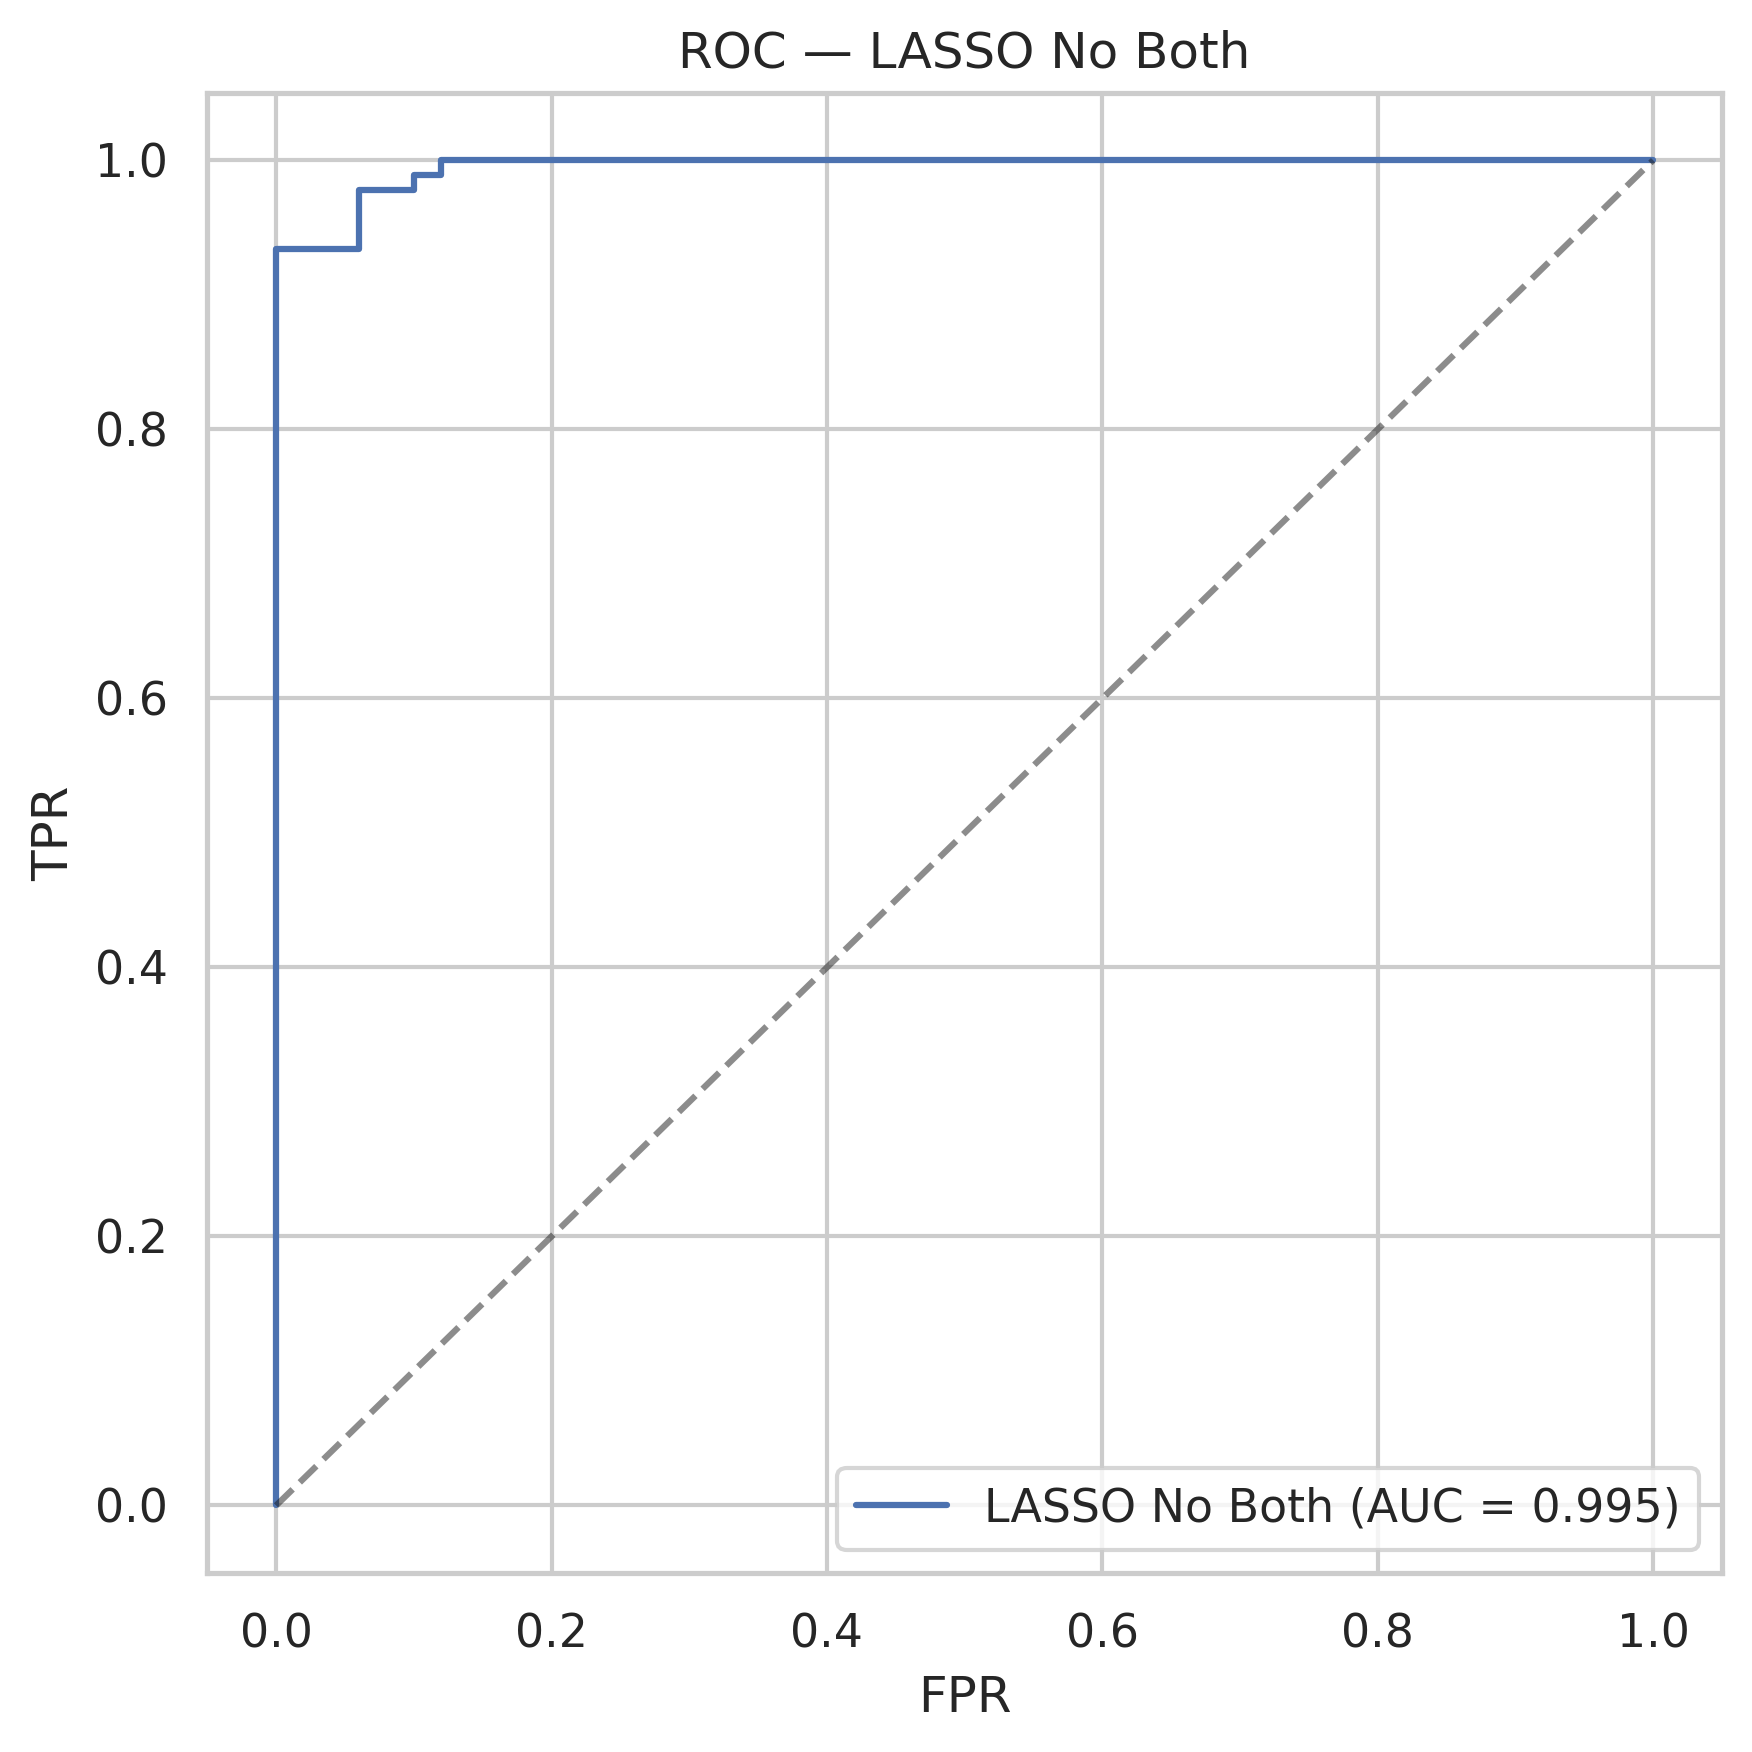

Confusion and report — LASSO No Both
[[47  3]
 [ 3 88]]
              precision    recall  f1-score   support

          No       0.94      0.94      0.94        50
         Yes       0.97      0.97      0.97        91

    accuracy                           0.96       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



In [50]:
# Step 21: Alternative LASSO "No Both" predictions and ROC

# Romove the variables from X
X_nb = variants['No Both']
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_nb, y, test_size=0.2, random_state=42, stratify=y)

# re-writing the pipeline to fit de model
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])
pipeline_nb.fit(X_train_nb, y_train_nb)
coefs_nb = pd.Series(pipeline_nb.named_steps['lasso'].coef_[0], index=X_train_nb.columns)
print("Variables retained in 'No Both' model:")
print(coefs_nb[coefs_nb.abs()>1e-6].sort_values(ascending=False))

# Ploting ROC
y_score_nb = pipeline_nb.predict_proba(X_test_nb)[:,1]
plt.figure(figsize=(6,6), dpi=300)
plot_roc(y_test_nb, y_score_nb, label='LASSO No Both')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — LASSO No Both'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# Prediction, confusion matrix and classification report
print("Confusion and report — LASSO No Both")
y_pred_nb = (y_score_nb>=0.5).astype(int)
print(confusion_matrix(y_test_nb, y_pred_nb))
print(classification_report(y_test_nb, y_pred_nb, target_names=['No','Yes']))

Demographics-only AUC (15-fold): 0.972 ± 0.029


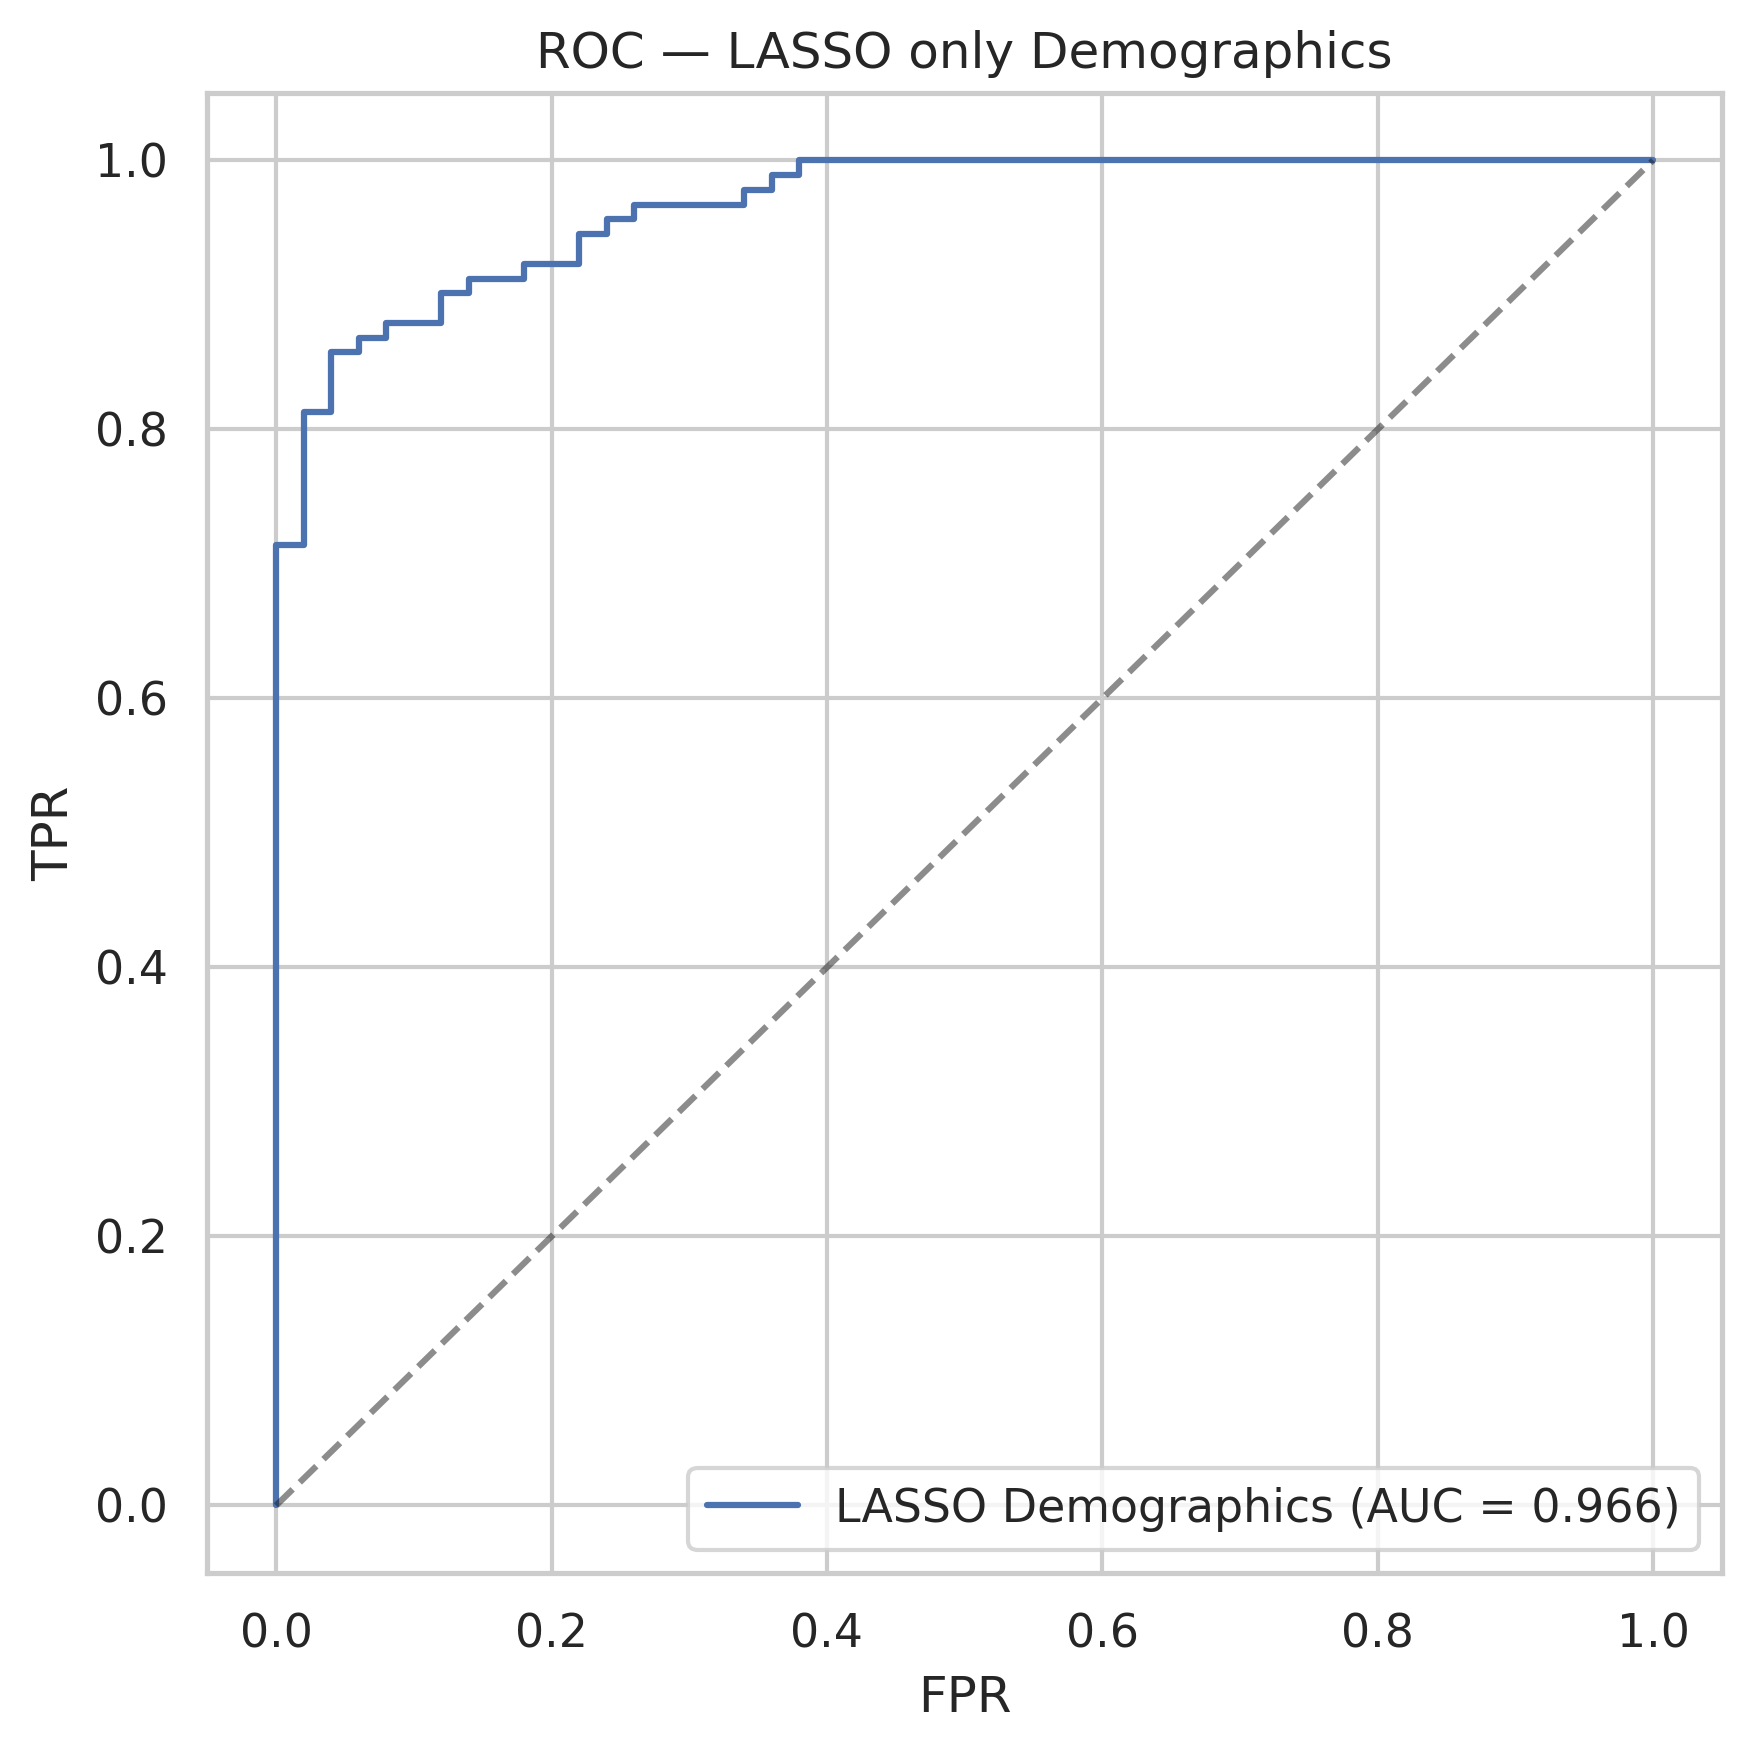

Non-zero coefs — Demographics-only
DailyUsageHours                        2.384791
Most_Used_Platform_TikTok              1.571498
Most_Used_Platform_Instagram           1.071005
Most_Used_Platform_KakaoTalk           0.756484
Most_Used_Platform_Snapchat            0.524909
Most_Used_Platform_WhatsApp            0.291293
Gender_Male                            0.241611
Most_Used_Platform_WeChat              0.142960
Relationship_Status_Single             0.099784
Most_Used_Platform_Twitter             0.053119
Most_Used_Platform_LINE               -0.072910
Most_Used_Platform_LinkedIn           -0.137586
Most_Used_Platform_VKontakte          -0.449256
Relationship_Status_In Relationship   -0.780882
Academic_Level_High School            -0.883375
Age                                   -0.909663
Academic_Level_Undergraduate          -1.235723
SleepHours                            -1.507265
dtype: float64
Confusion and report — LASSO only Demographics
[[44  6]
 [10 81]]
              precis

In [51]:
# Step 22: LASSO only demographic variables

# Remove selected variables from X
X_clean = X.drop(columns=['Addicted_Score','Conflicts_Over_Social_Media','Mental_Health_Score'])
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y)

# re-writing the pipeline to fit de model
pipe_clean = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))])
cv_auc_clean = cross_val_score(pipe_clean, X_clean, y, cv=15, scoring='roc_auc')
print(f"Demographics-only AUC (15-fold): {cv_auc_clean.mean():.3f} ± {cv_auc_clean.std():.3f}")

pipe_clean.fit(X_train_clean, y_train_clean)
y_score_clean = pipe_clean.predict_proba(X_test_clean)[:, 1]

# Ploting ROC
plt.figure(figsize=(6,6), dpi=300)
plot_roc(train_test_split(X_clean, y, test_size=0.2, random_state=42, stratify=y)[3], y_score_clean, label='LASSO Demographics')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — LASSO only Demographics'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

print("Non-zero coefs — Demographics-only")
coefs_clean = pd.Series(pipe_clean.named_steps['lasso'].coef_[0], index=X_clean.columns)
print(coefs_clean[coefs_clean.abs()>1e-6].sort_values(ascending=False))

# Prediction, confusion matrix and classification report
print("Confusion and report — LASSO only Demographics")
y_pred_clean = (y_score_clean>=0.5).astype(int)
print(confusion_matrix(y_test_clean, y_pred_clean))
print(classification_report(y_test_clean, y_pred_clean, target_names=['No','Yes']))

In [52]:
# Step 23: Random Forest Evaluation Function

def evaluate_rf(name, X_tr, y_tr, X_te, y_te):
    print(f"{name} - Random Forest Evaluation")
    # Initialize and train model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr, y_tr)
    # Predict probabilities
    y_score = rf.predict_proba(X_te)[:, 1]

    # ROC Curve and AUC
    plt.figure(figsize=(6, 6), dpi=300)
    roc_auc = plot_roc(y_te, y_score, label=name)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name} (AUC = {roc_auc:.3f})')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Confusion Matrix and Classification Report
    y_pred = (y_score >= 0.5).astype(int)
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['No', 'Yes']))

    # Feature Importances
    importances = pd.Series(rf.feature_importances_, index=X_tr.columns)
    importances = importances.sort_values(ascending=False)
    plt.figure(figsize=(8, 6), dpi=300)
    importances.head(10).plot(kind='bar')
    plt.title(f'Top 10 Feature Importances - {name}')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

RF Full - Random Forest Evaluation


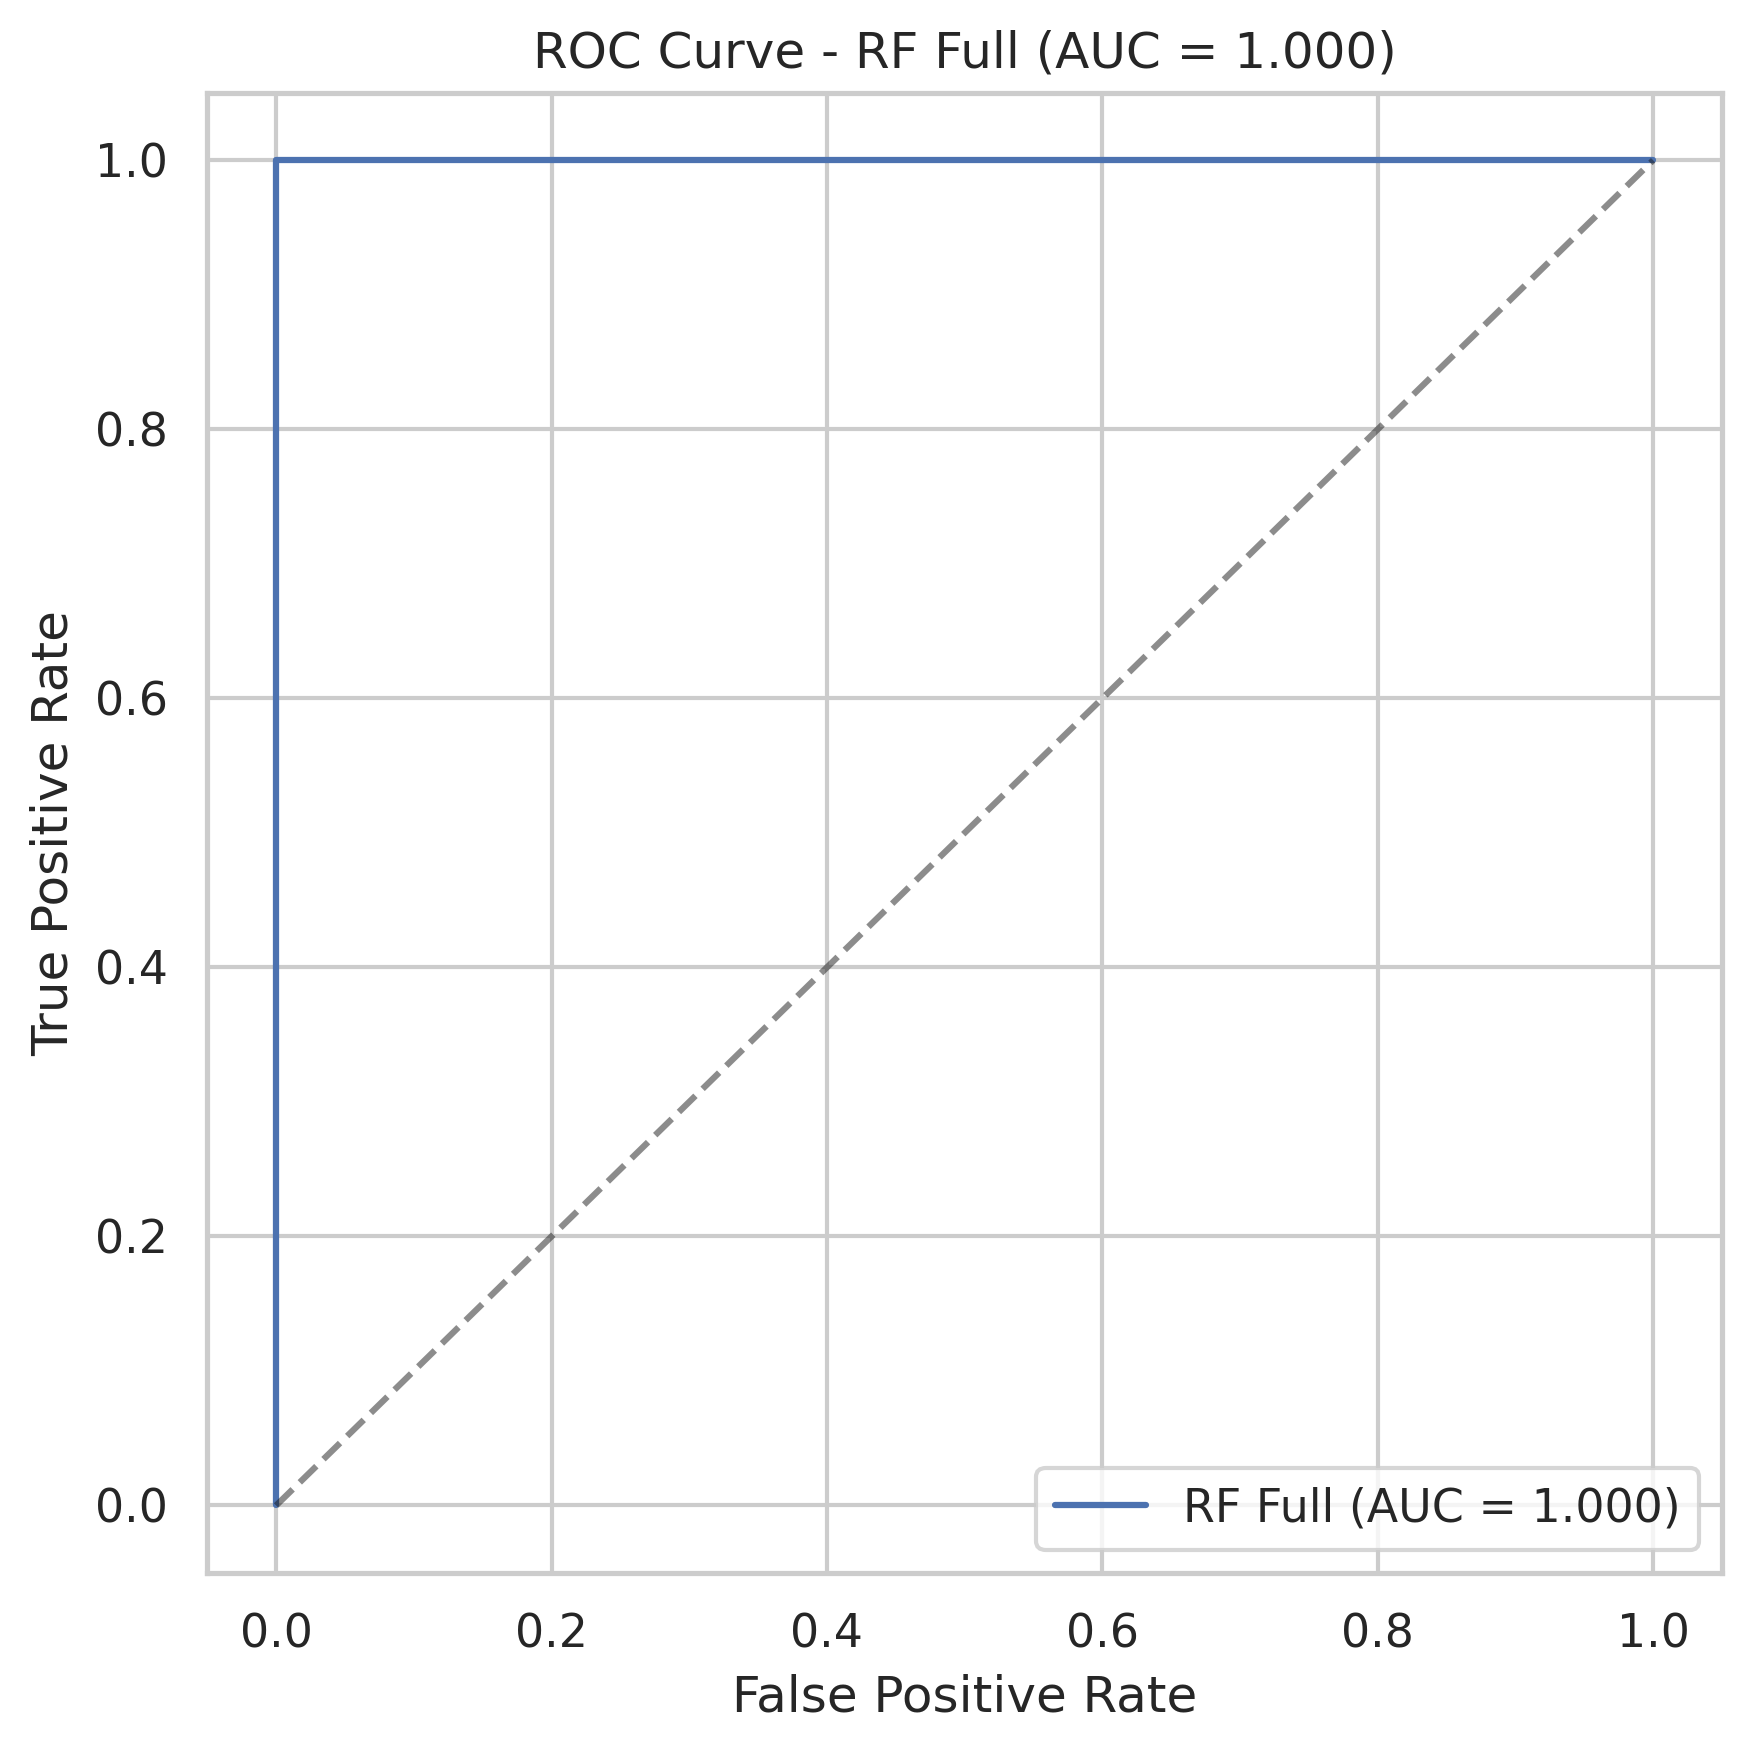

Confusion Matrix:
[[50  0]
 [ 0 91]]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



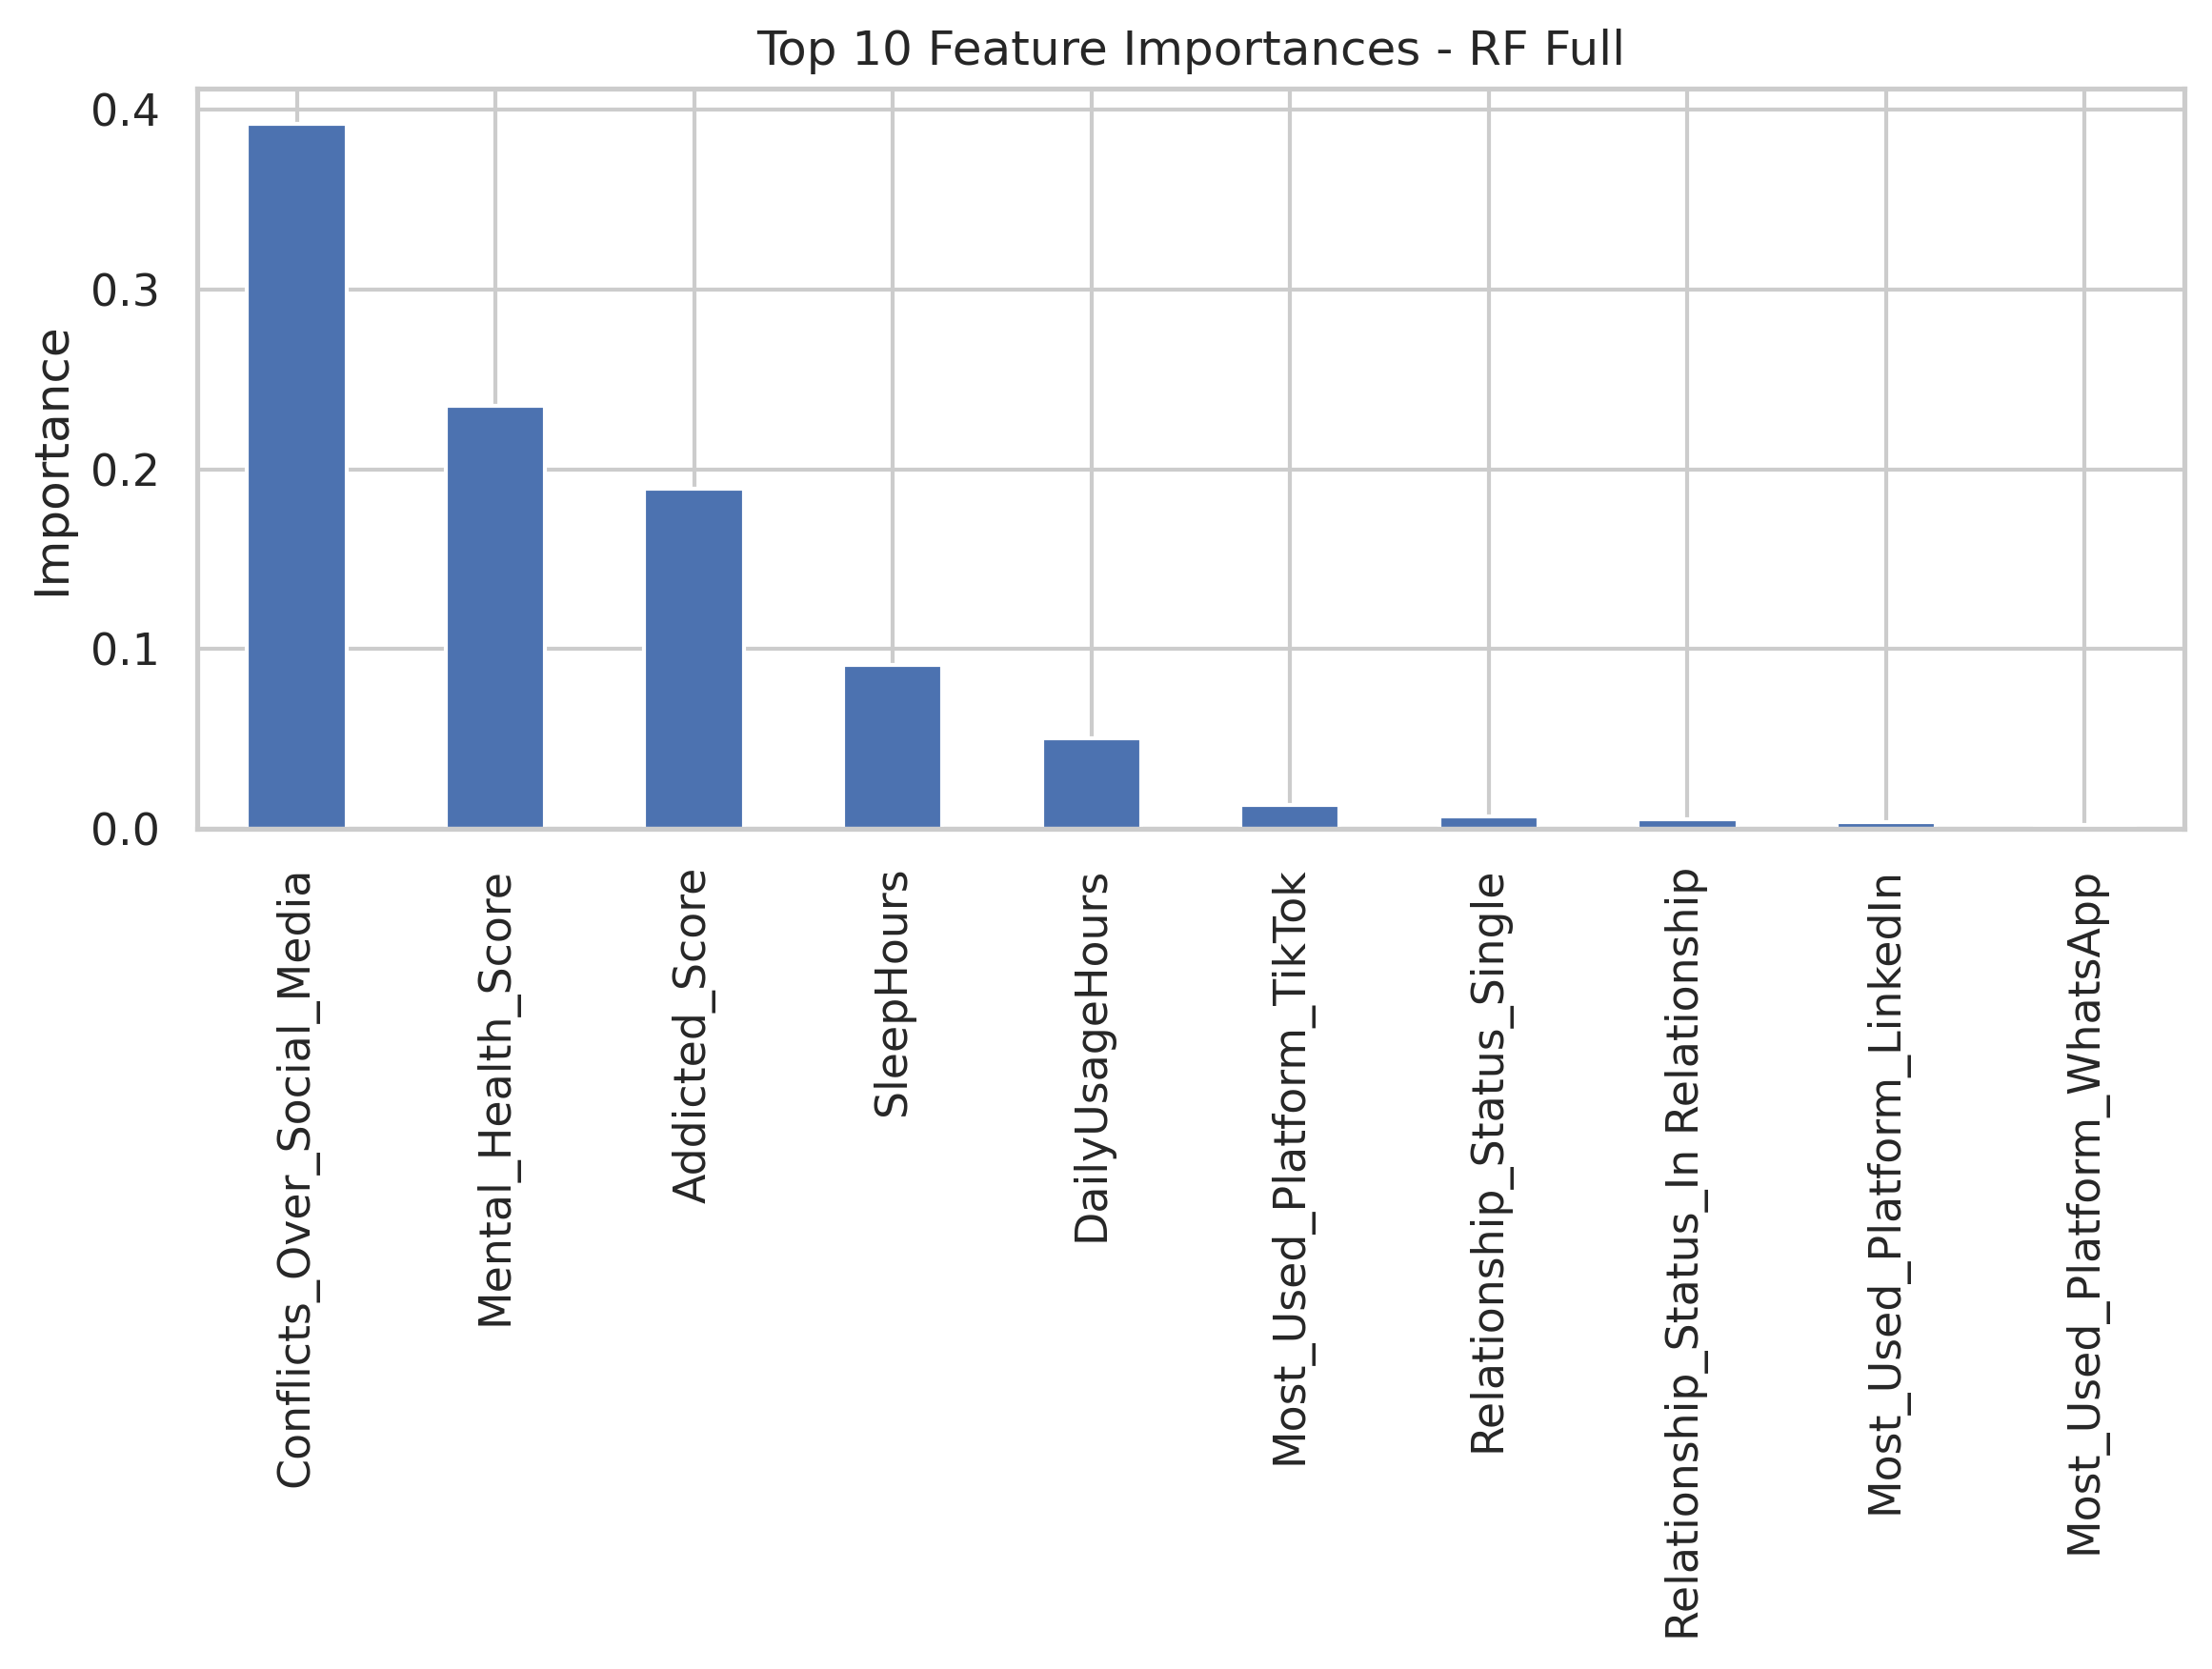

RF No Both - Random Forest Evaluation


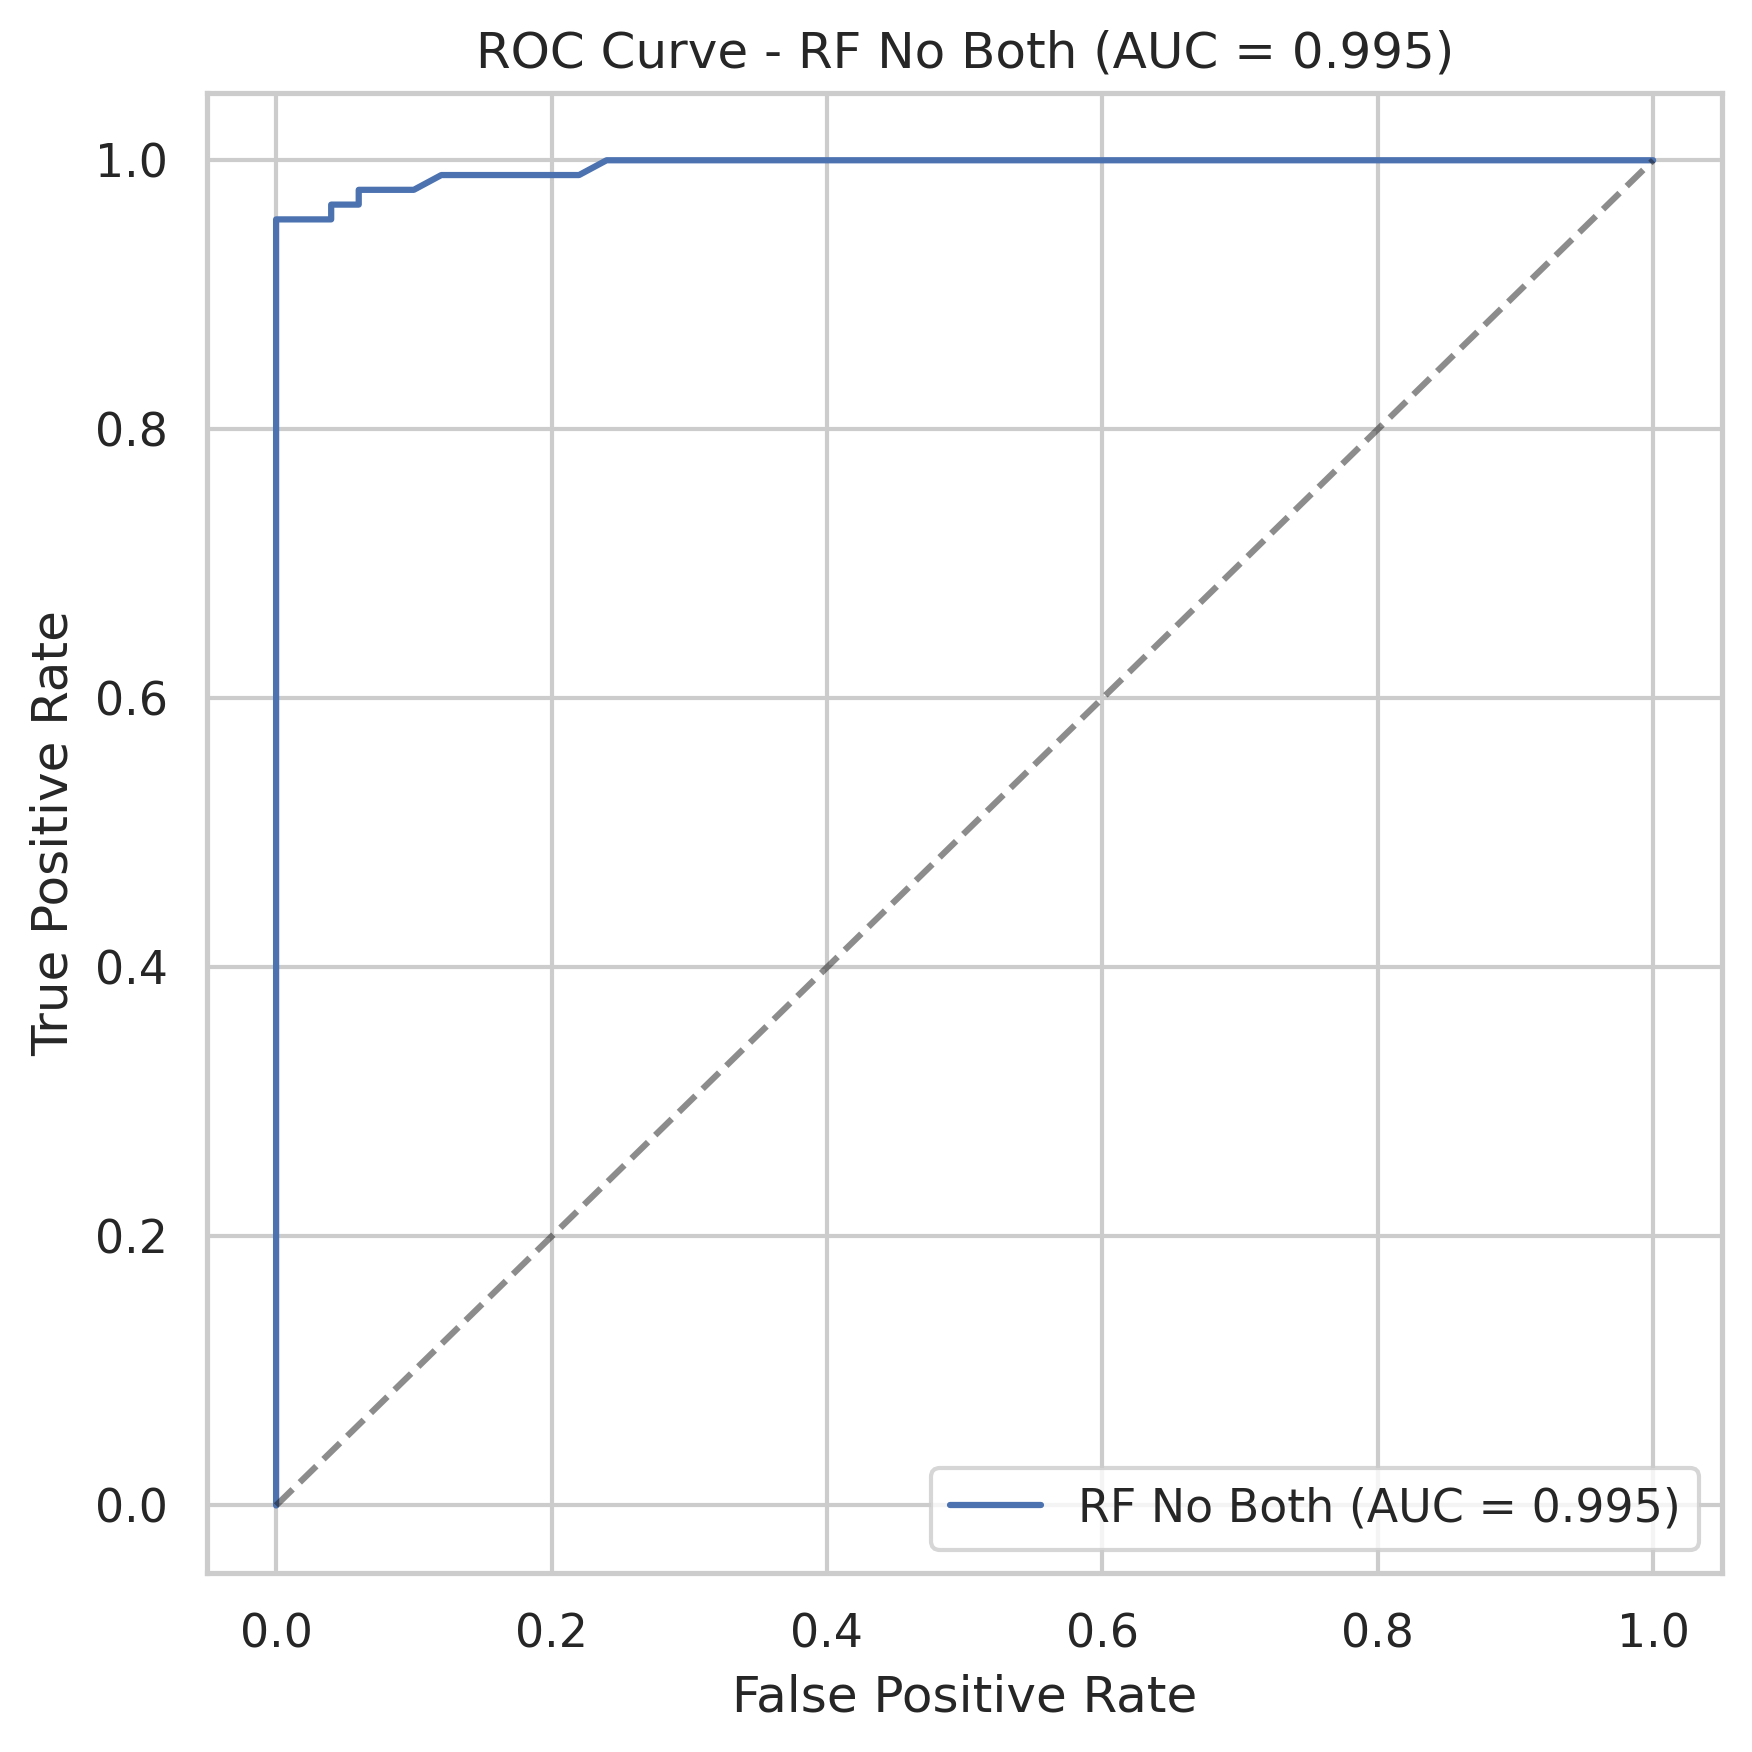

Confusion Matrix:
[[46  4]
 [ 2 89]]
              precision    recall  f1-score   support

          No       0.96      0.92      0.94        50
         Yes       0.96      0.98      0.97        91

    accuracy                           0.96       141
   macro avg       0.96      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



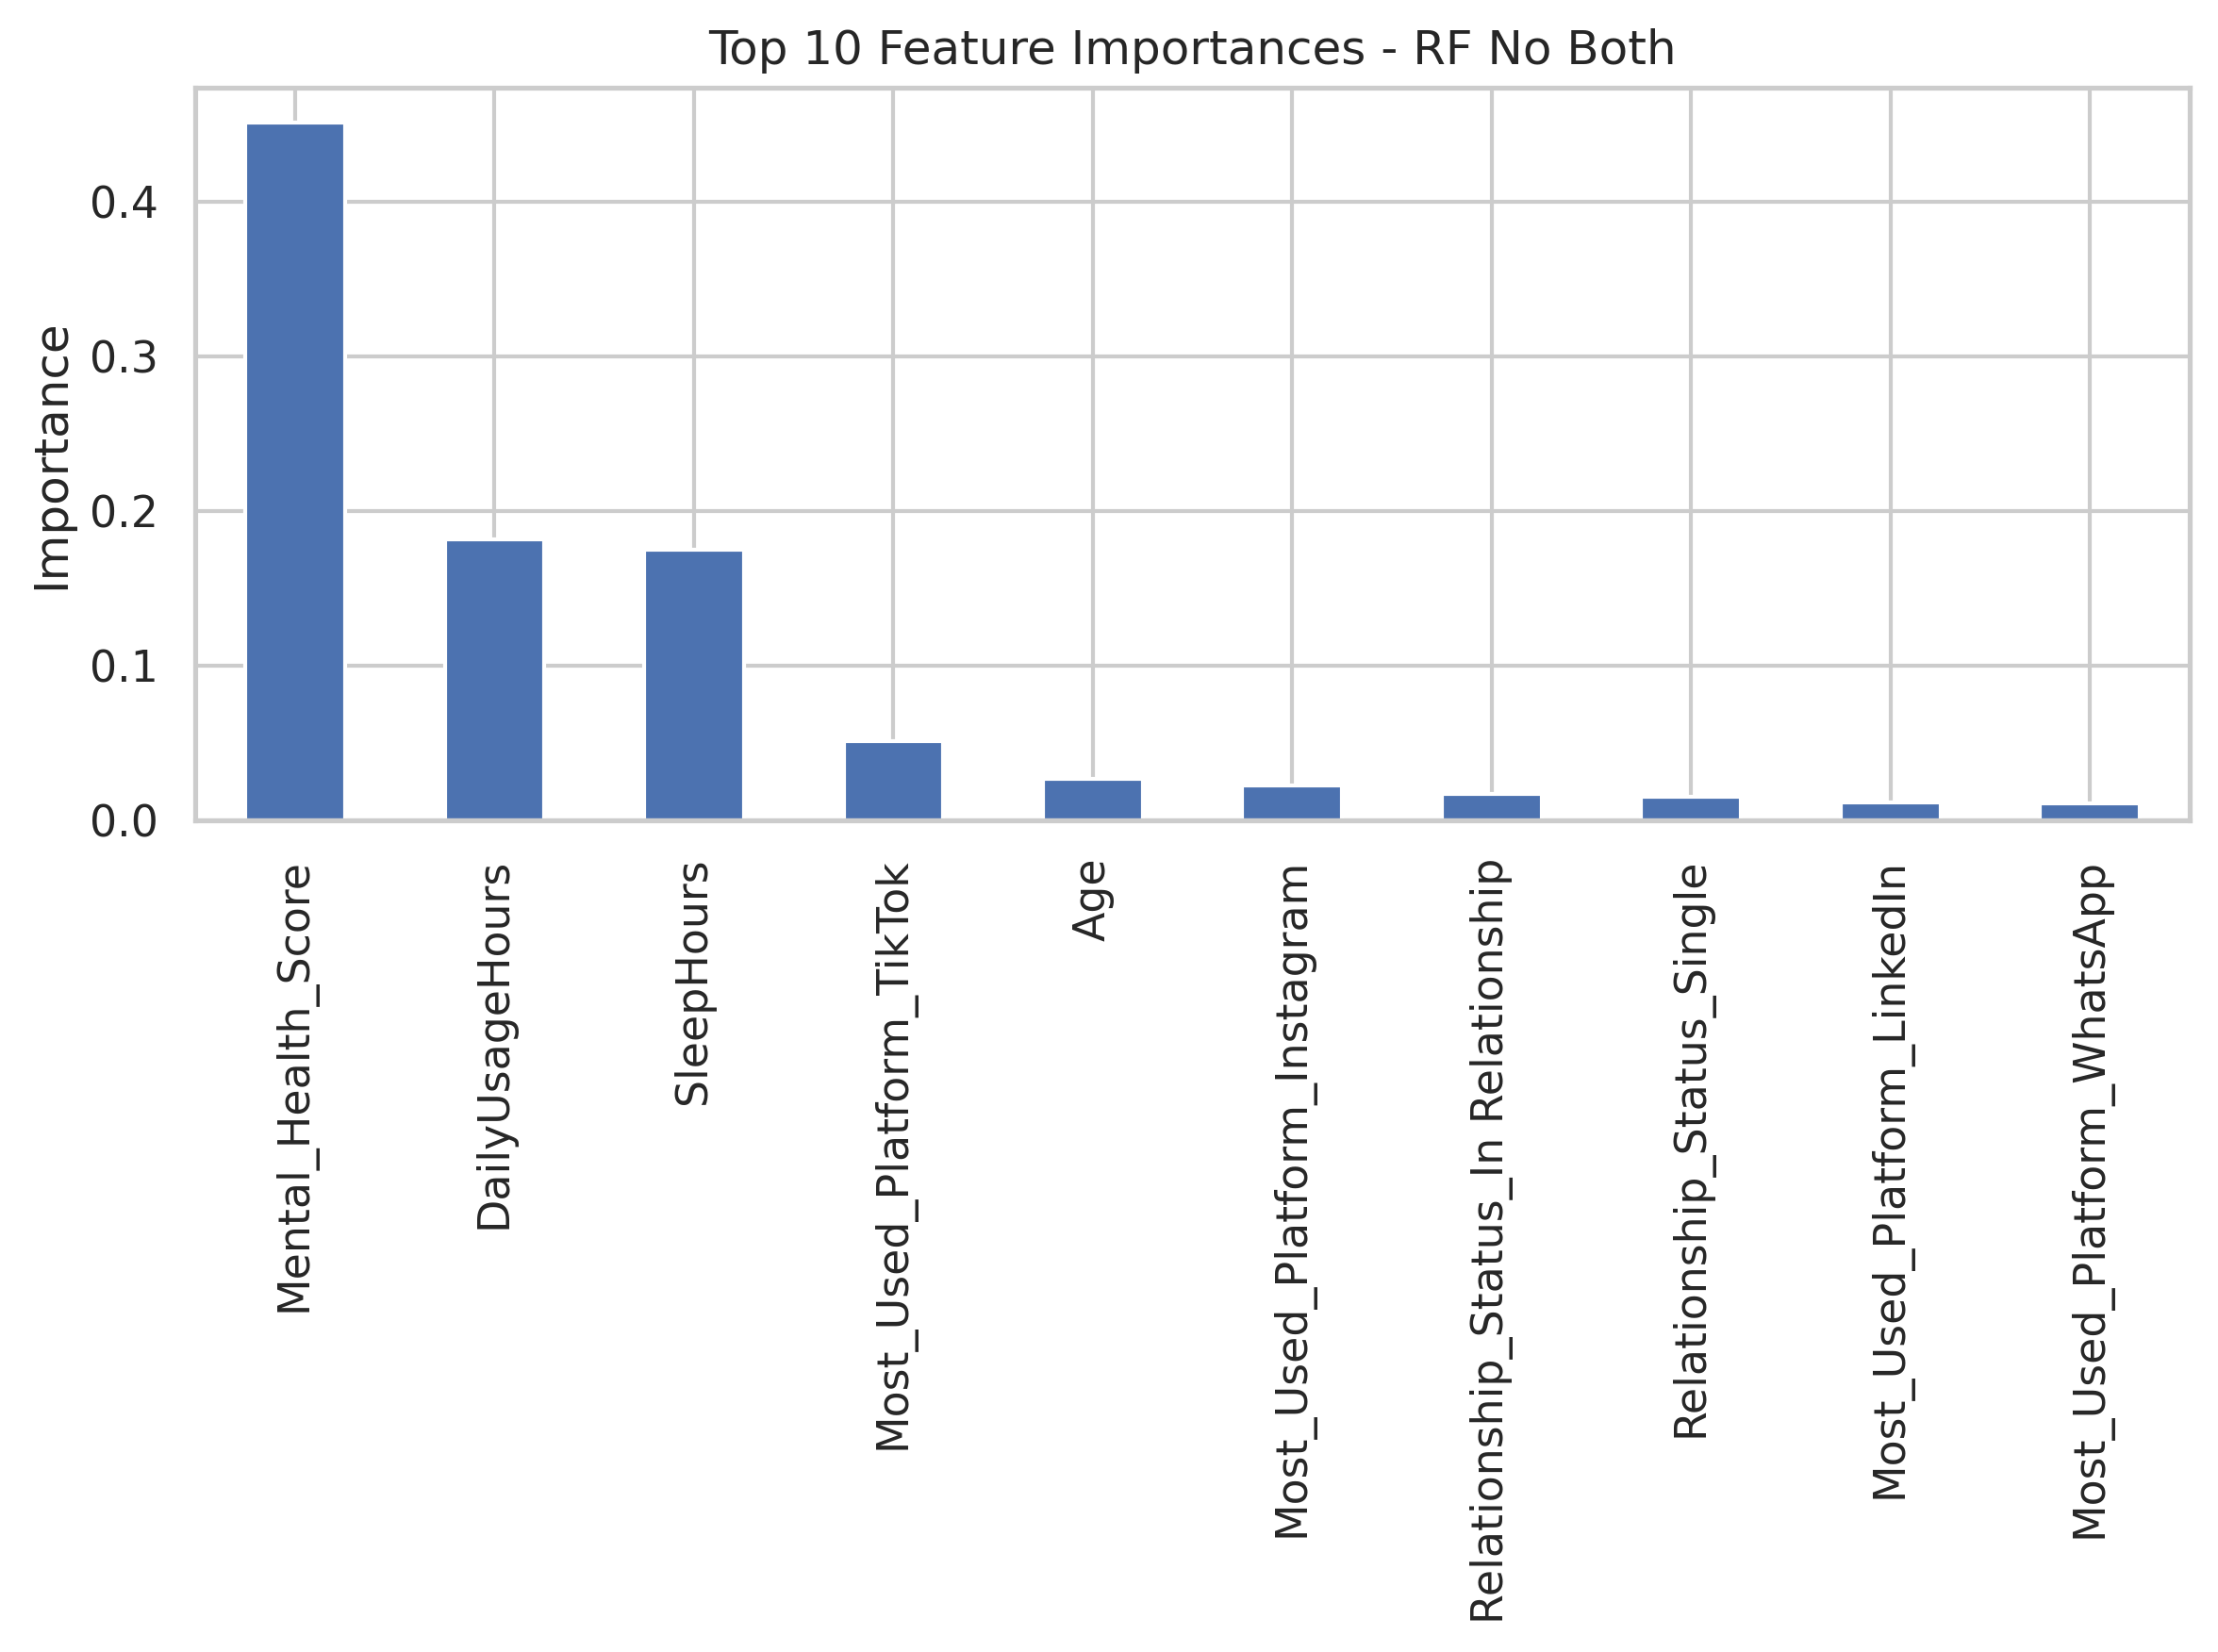

RF Demographics Only - Random Forest Evaluation


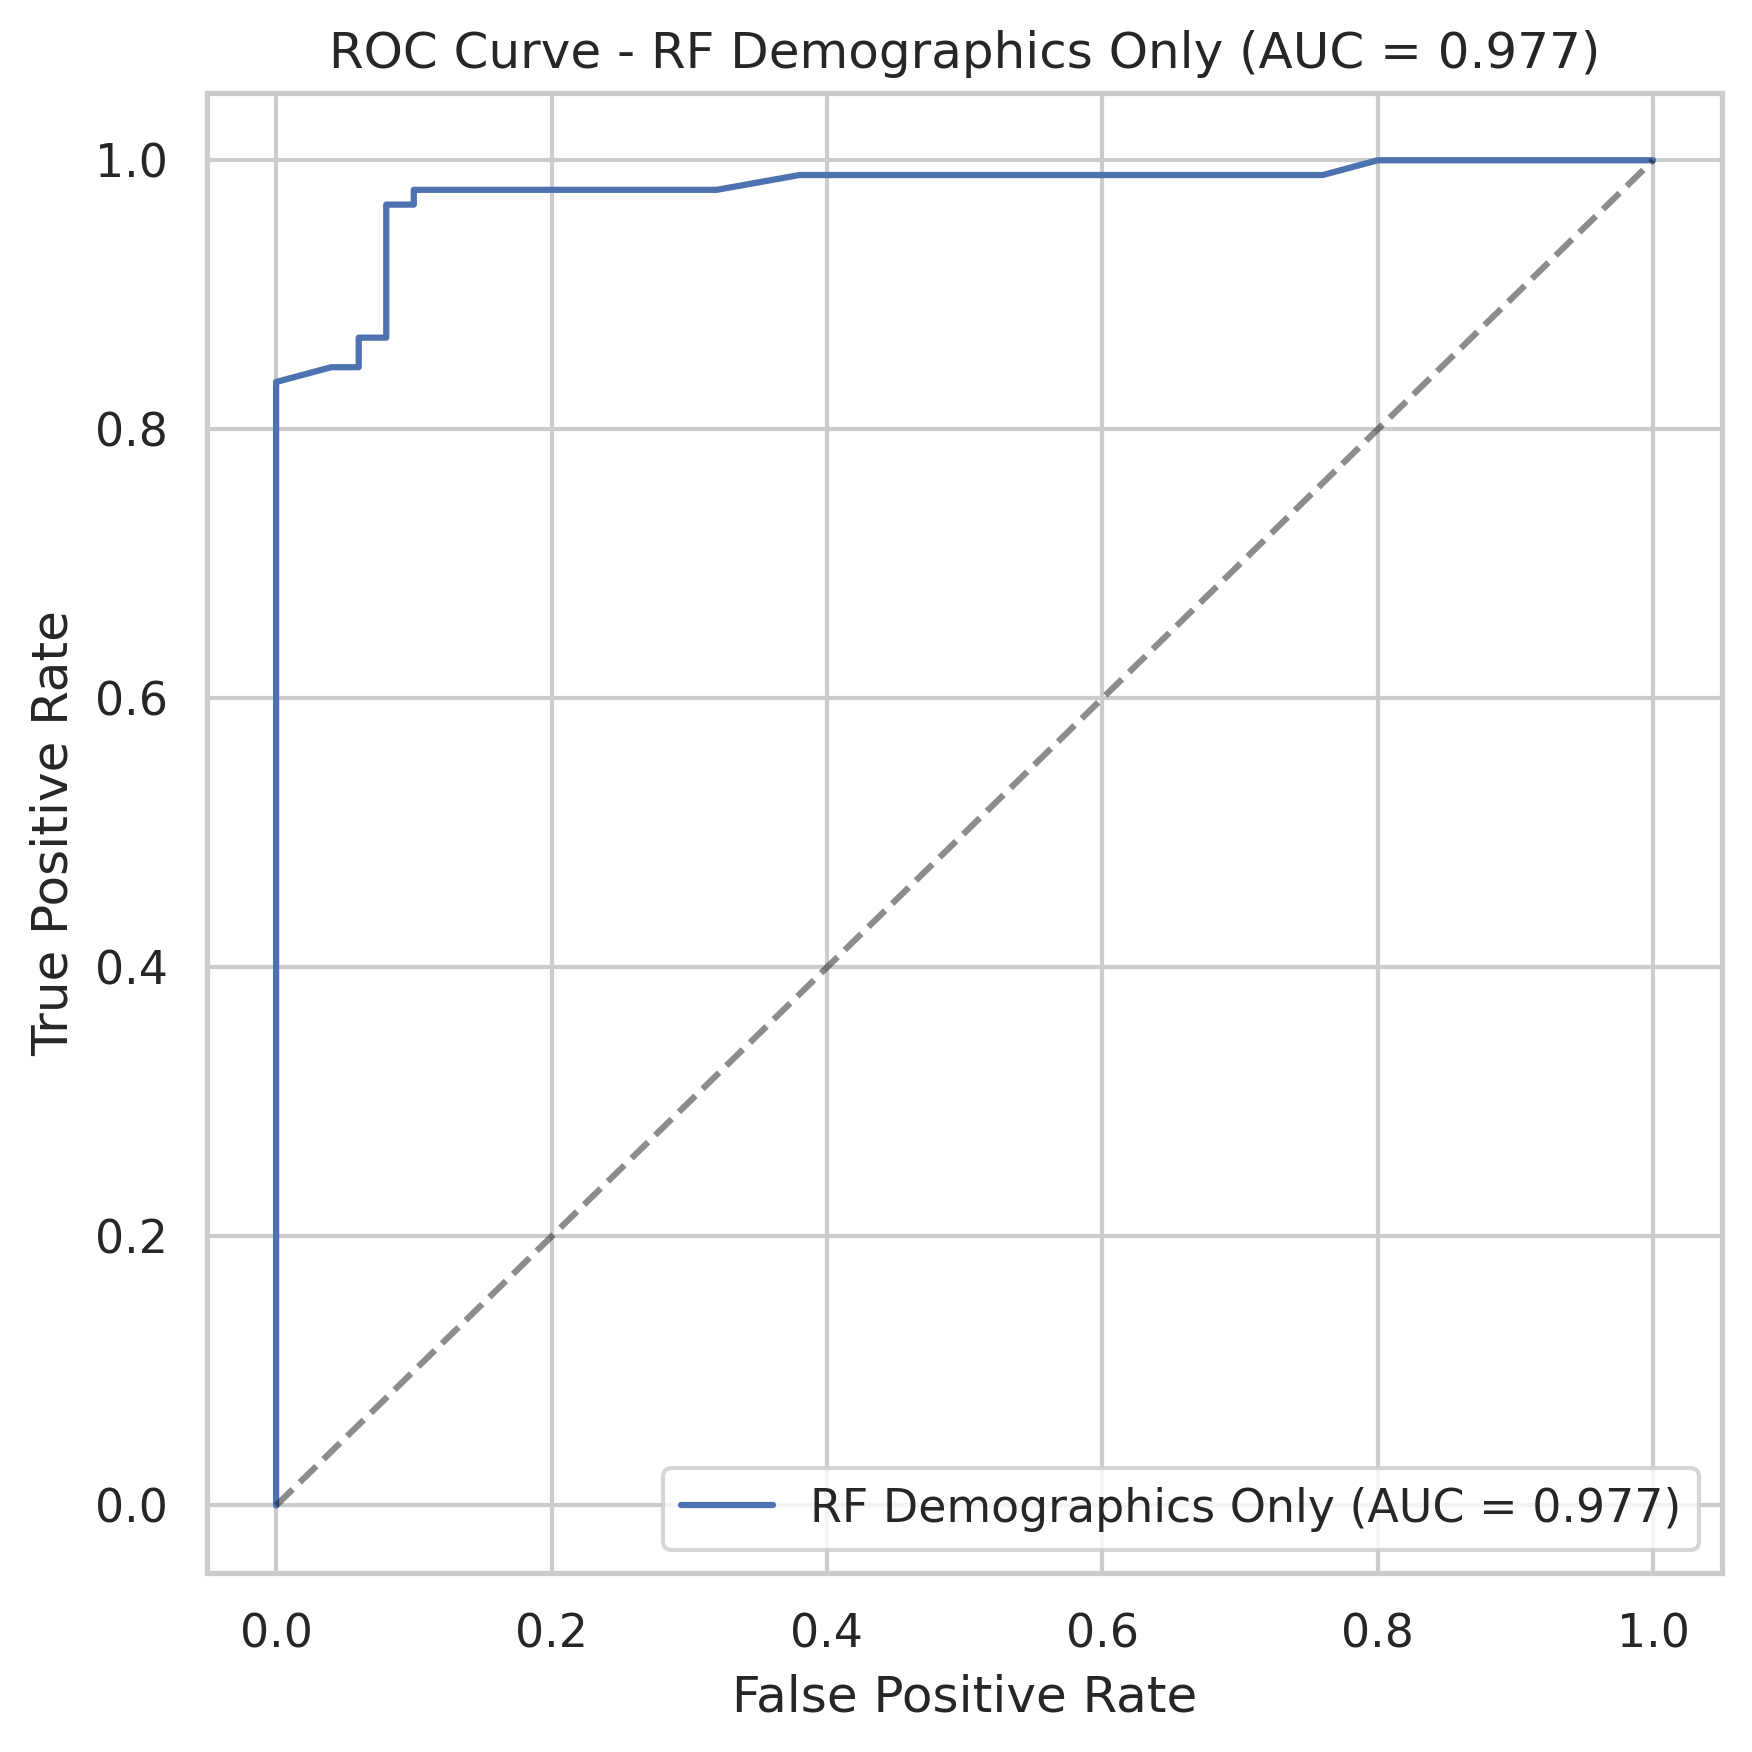

Confusion Matrix:
[[45  5]
 [ 2 89]]
              precision    recall  f1-score   support

          No       0.96      0.90      0.93        50
         Yes       0.95      0.98      0.96        91

    accuracy                           0.95       141
   macro avg       0.95      0.94      0.94       141
weighted avg       0.95      0.95      0.95       141



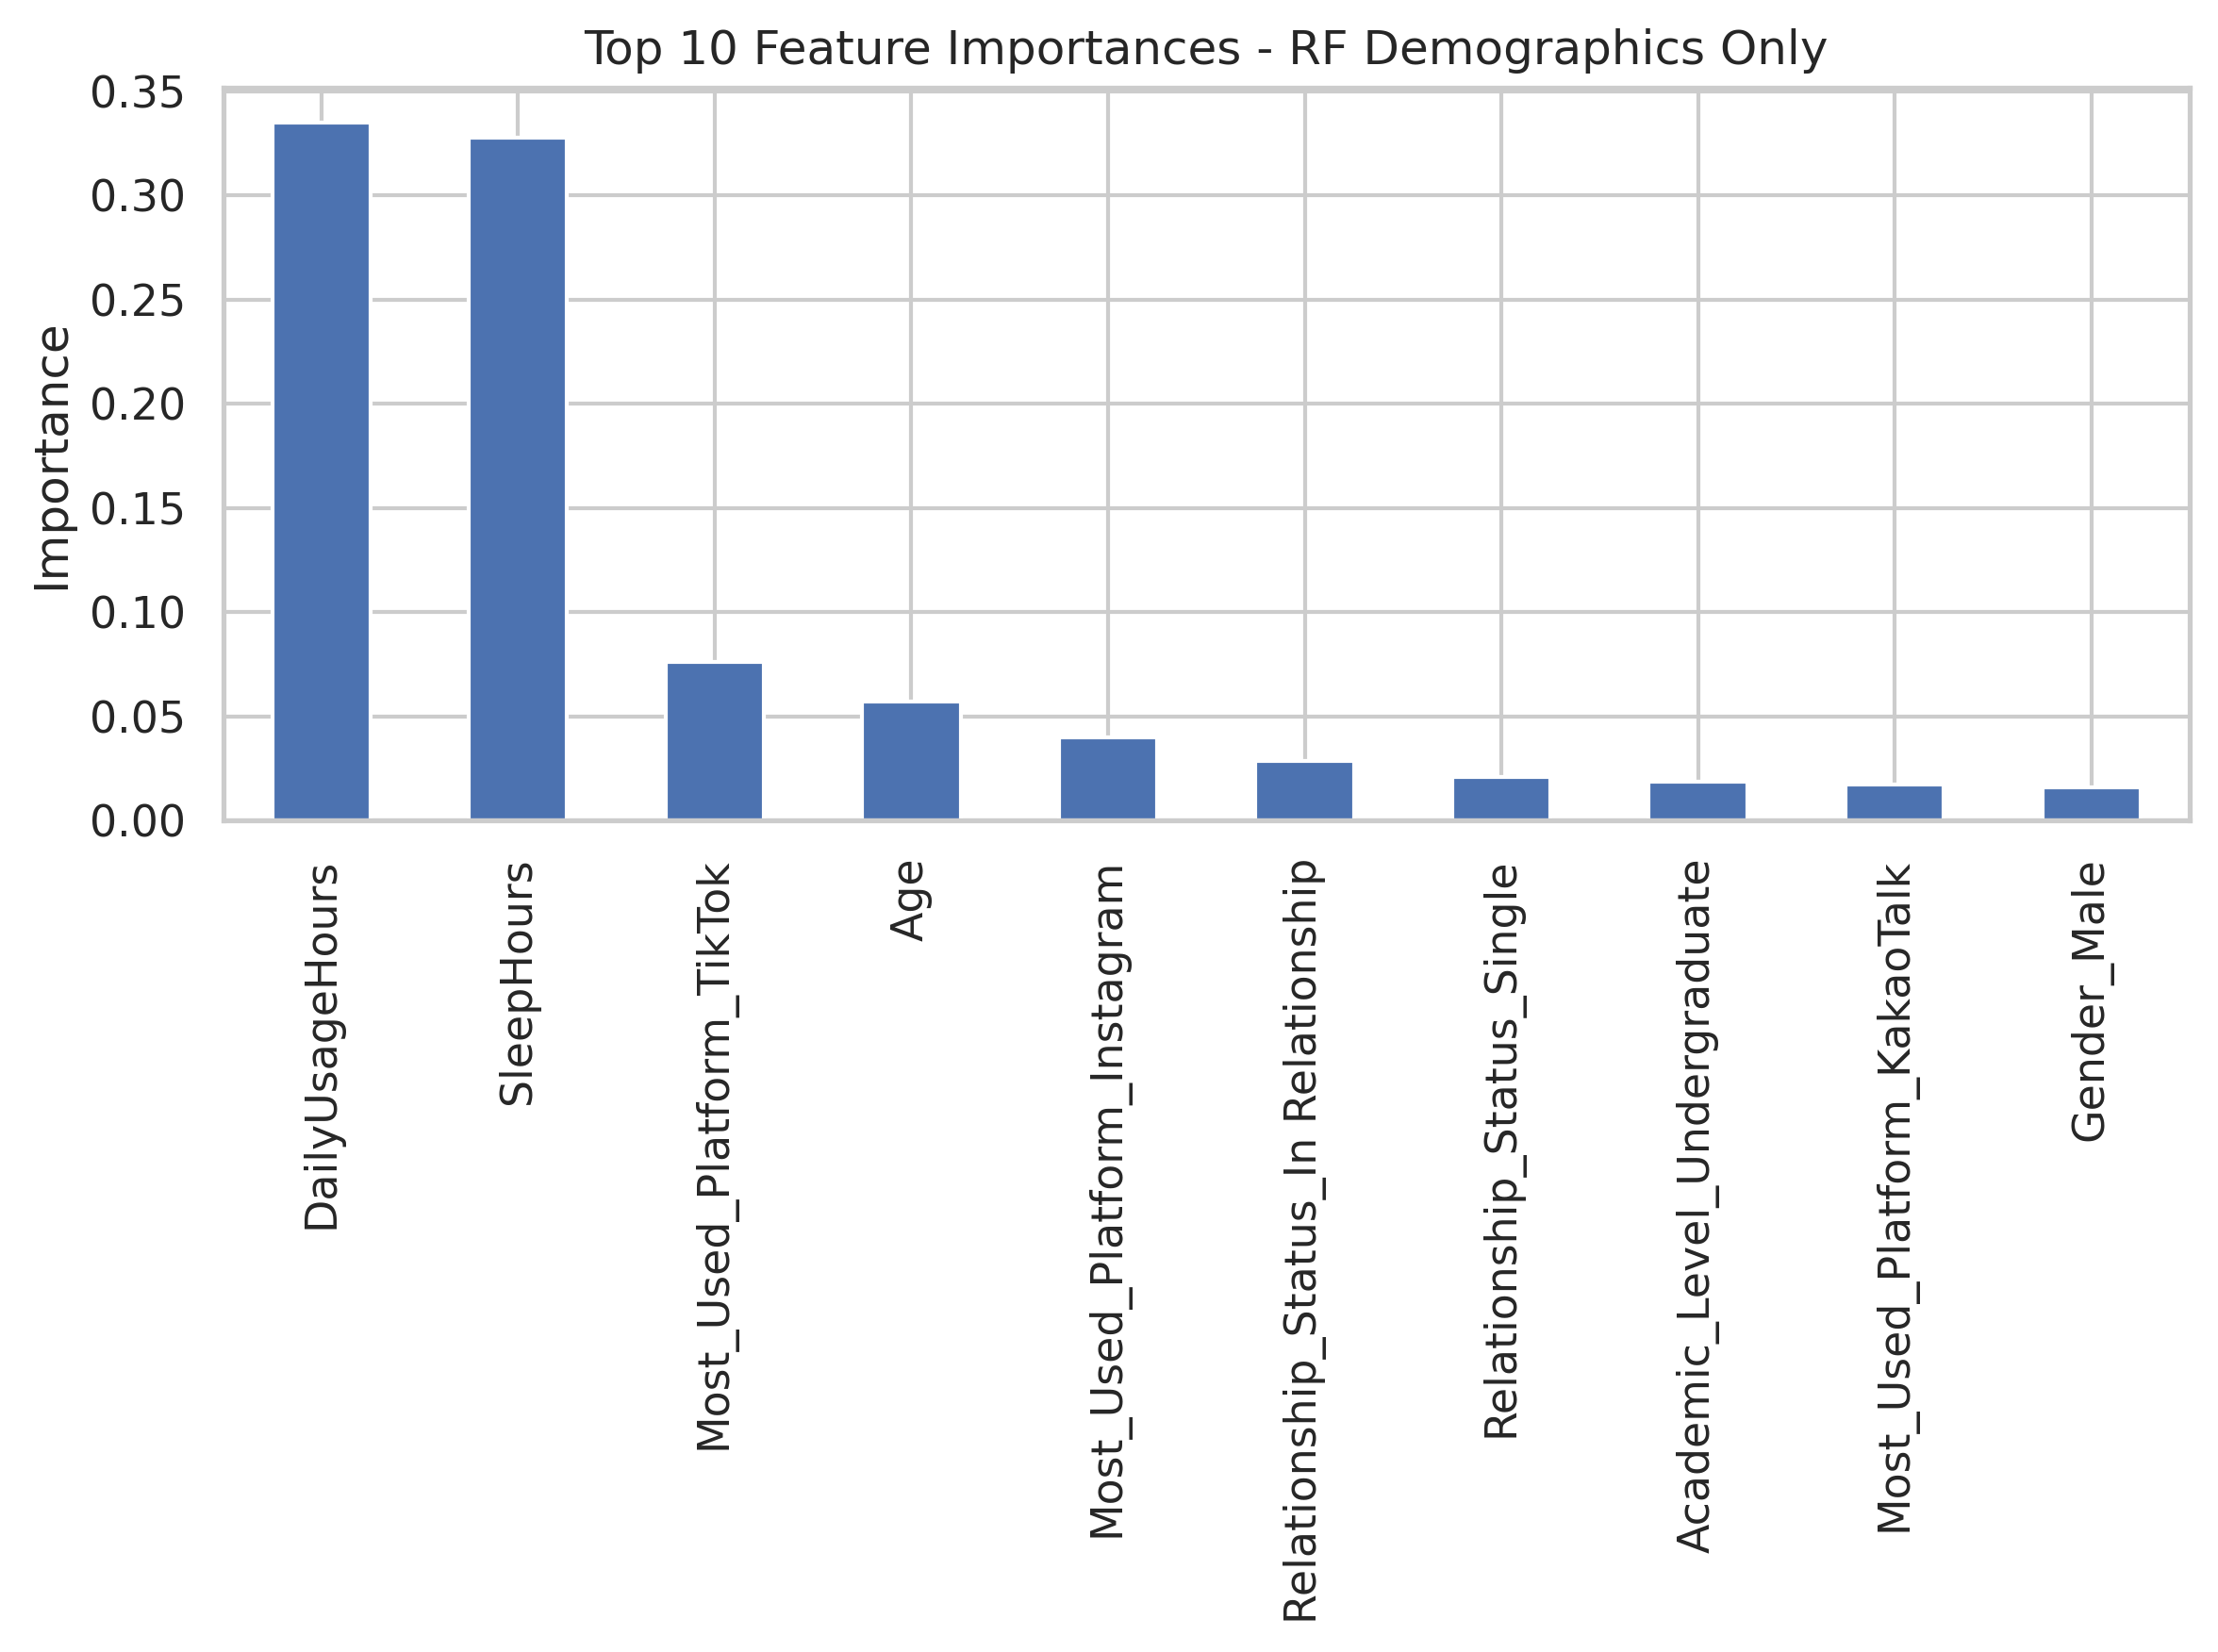

In [53]:
# Step 24: Execute Random Forest for each dataset variant

evaluate_rf("RF Full", X_train, y_train, X_test, y_test)
evaluate_rf("RF No Both", X_train_nb, y_train_nb, X_test_nb, y_test_nb)
evaluate_rf("RF Demographics Only", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

In [54]:
# Step 26: XGBoost Evaluation Function
def evaluate_xgb(name, X_tr, y_tr, X_te, y_te):
    print(f"{name} - XGBoost Evaluation")
    # Initialize and train model
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_tr, y_tr)
    # Predict probabilities
    y_score = xgb.predict_proba(X_te)[:, 1]

    # ROC Curve and AUC
    plt.figure(figsize=(6, 6), dpi=300)
    roc_auc = plot_roc(y_te, y_score, label=name)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name} (AUC = {roc_auc:.3f})')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Confusion Matrix and Classification Report
    y_pred = (y_score >= 0.5).astype(int)
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['No', 'Yes']))

    # Feature Importances
    importances = pd.Series(xgb.feature_importances_, index=X_tr.columns)
    importances = importances.sort_values(ascending=False)
    plt.figure(figsize=(8, 6), dpi=300)
    importances.head(10).plot(kind='bar')
    plt.title(f'Top 10 Feature Importances - {name}')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

XGB Full - XGBoost Evaluation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


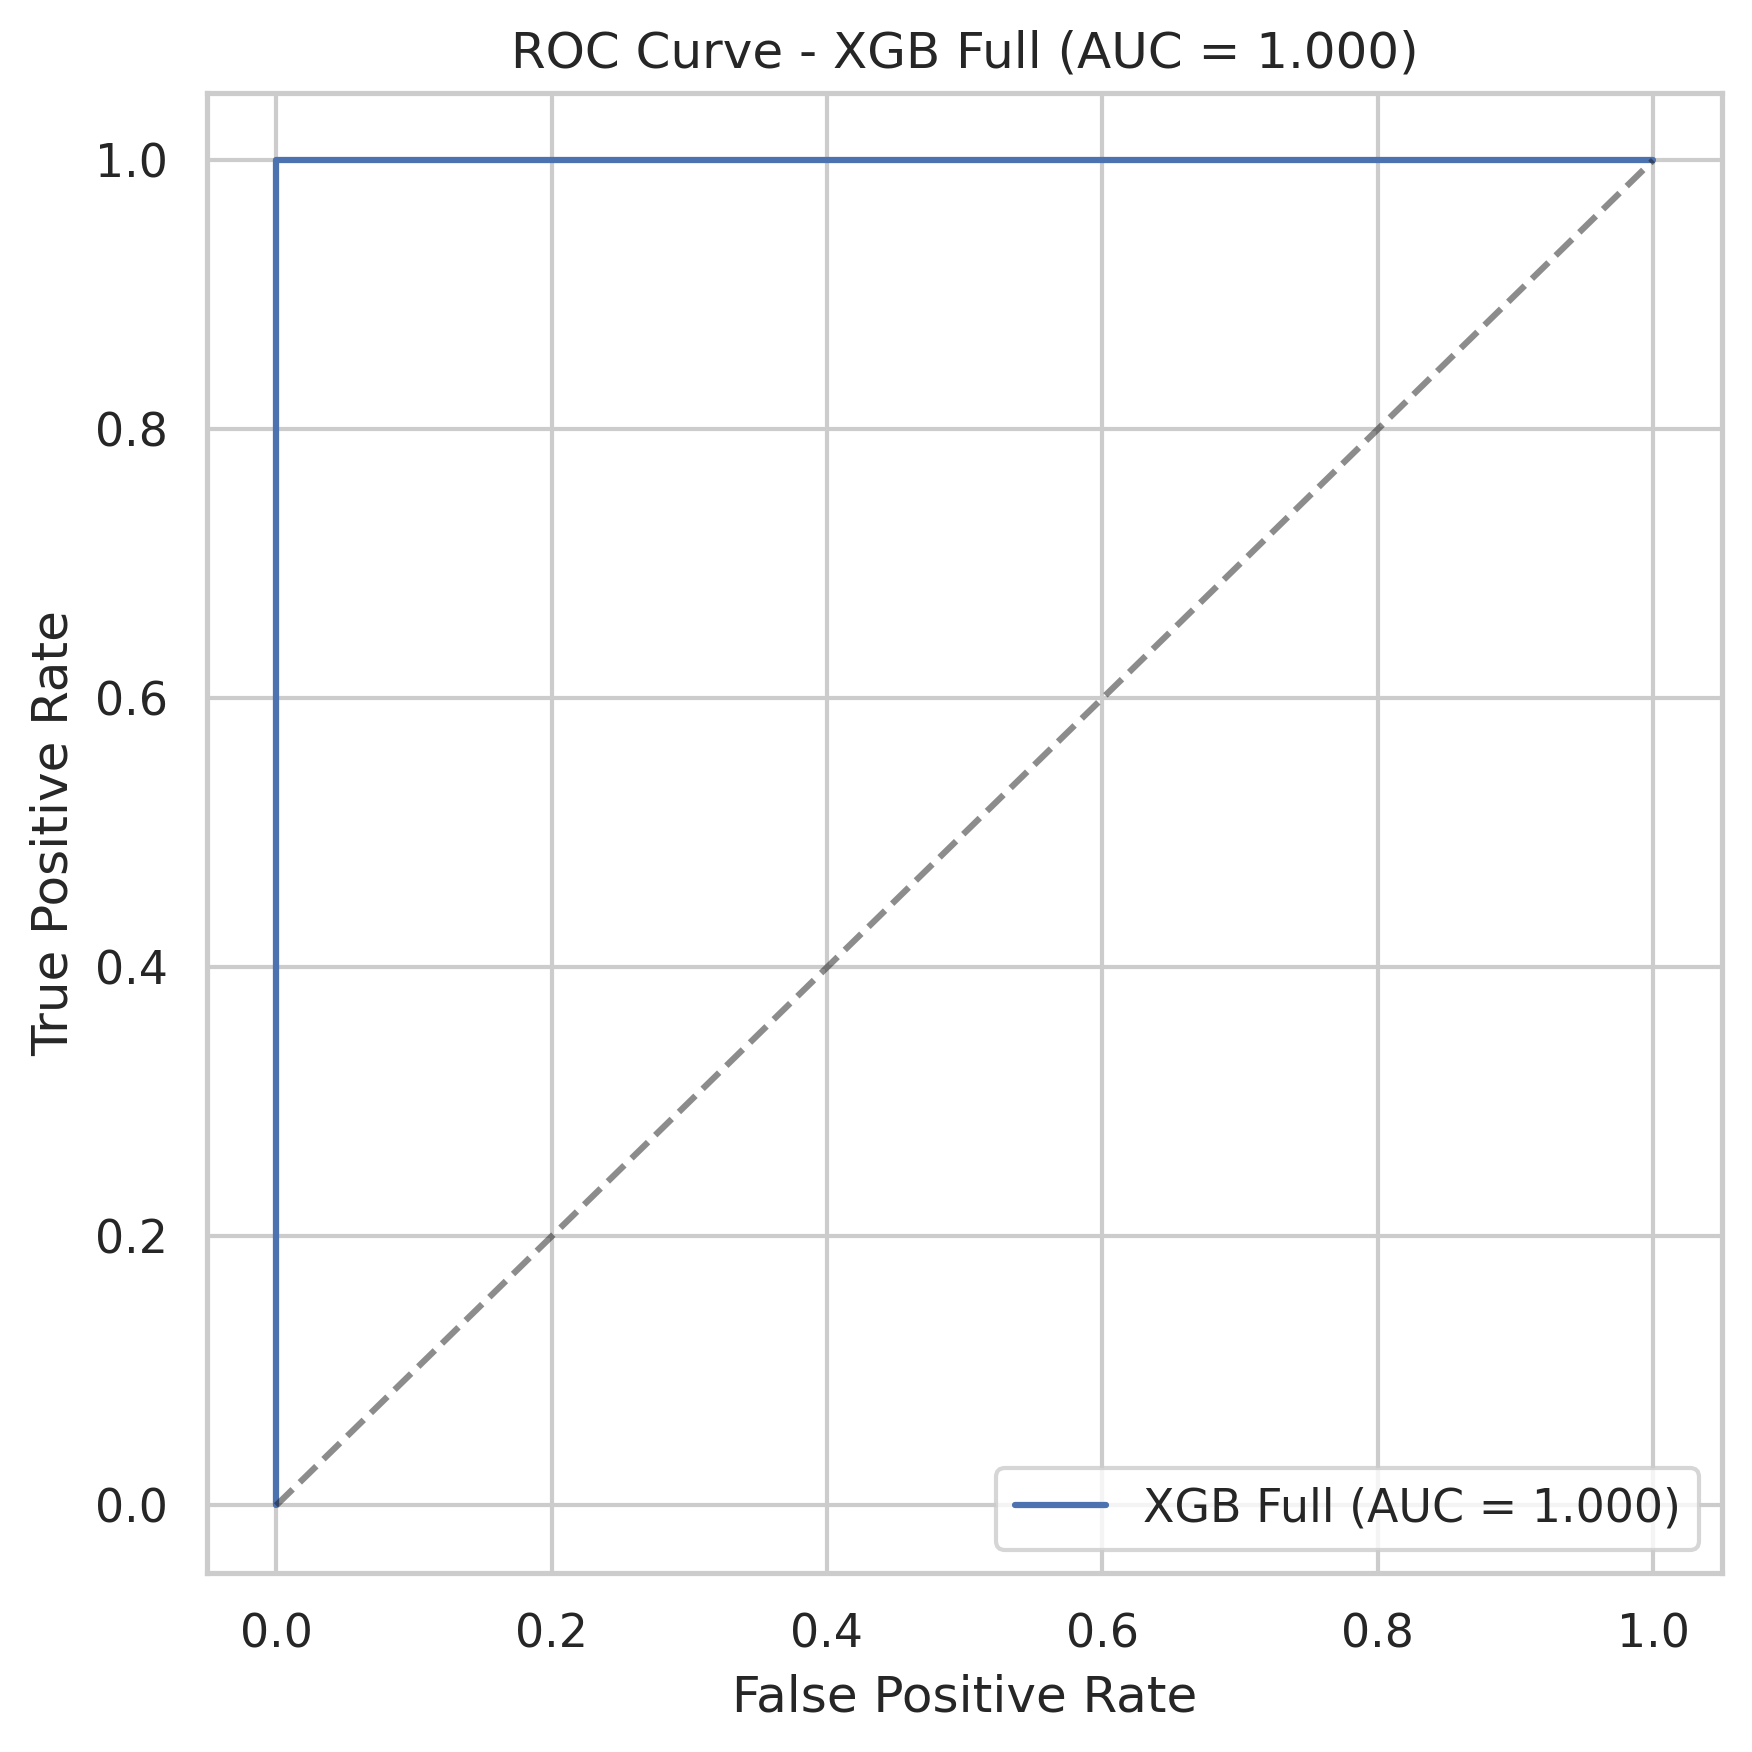

Confusion Matrix:
[[50  0]
 [ 0 91]]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        50
         Yes       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



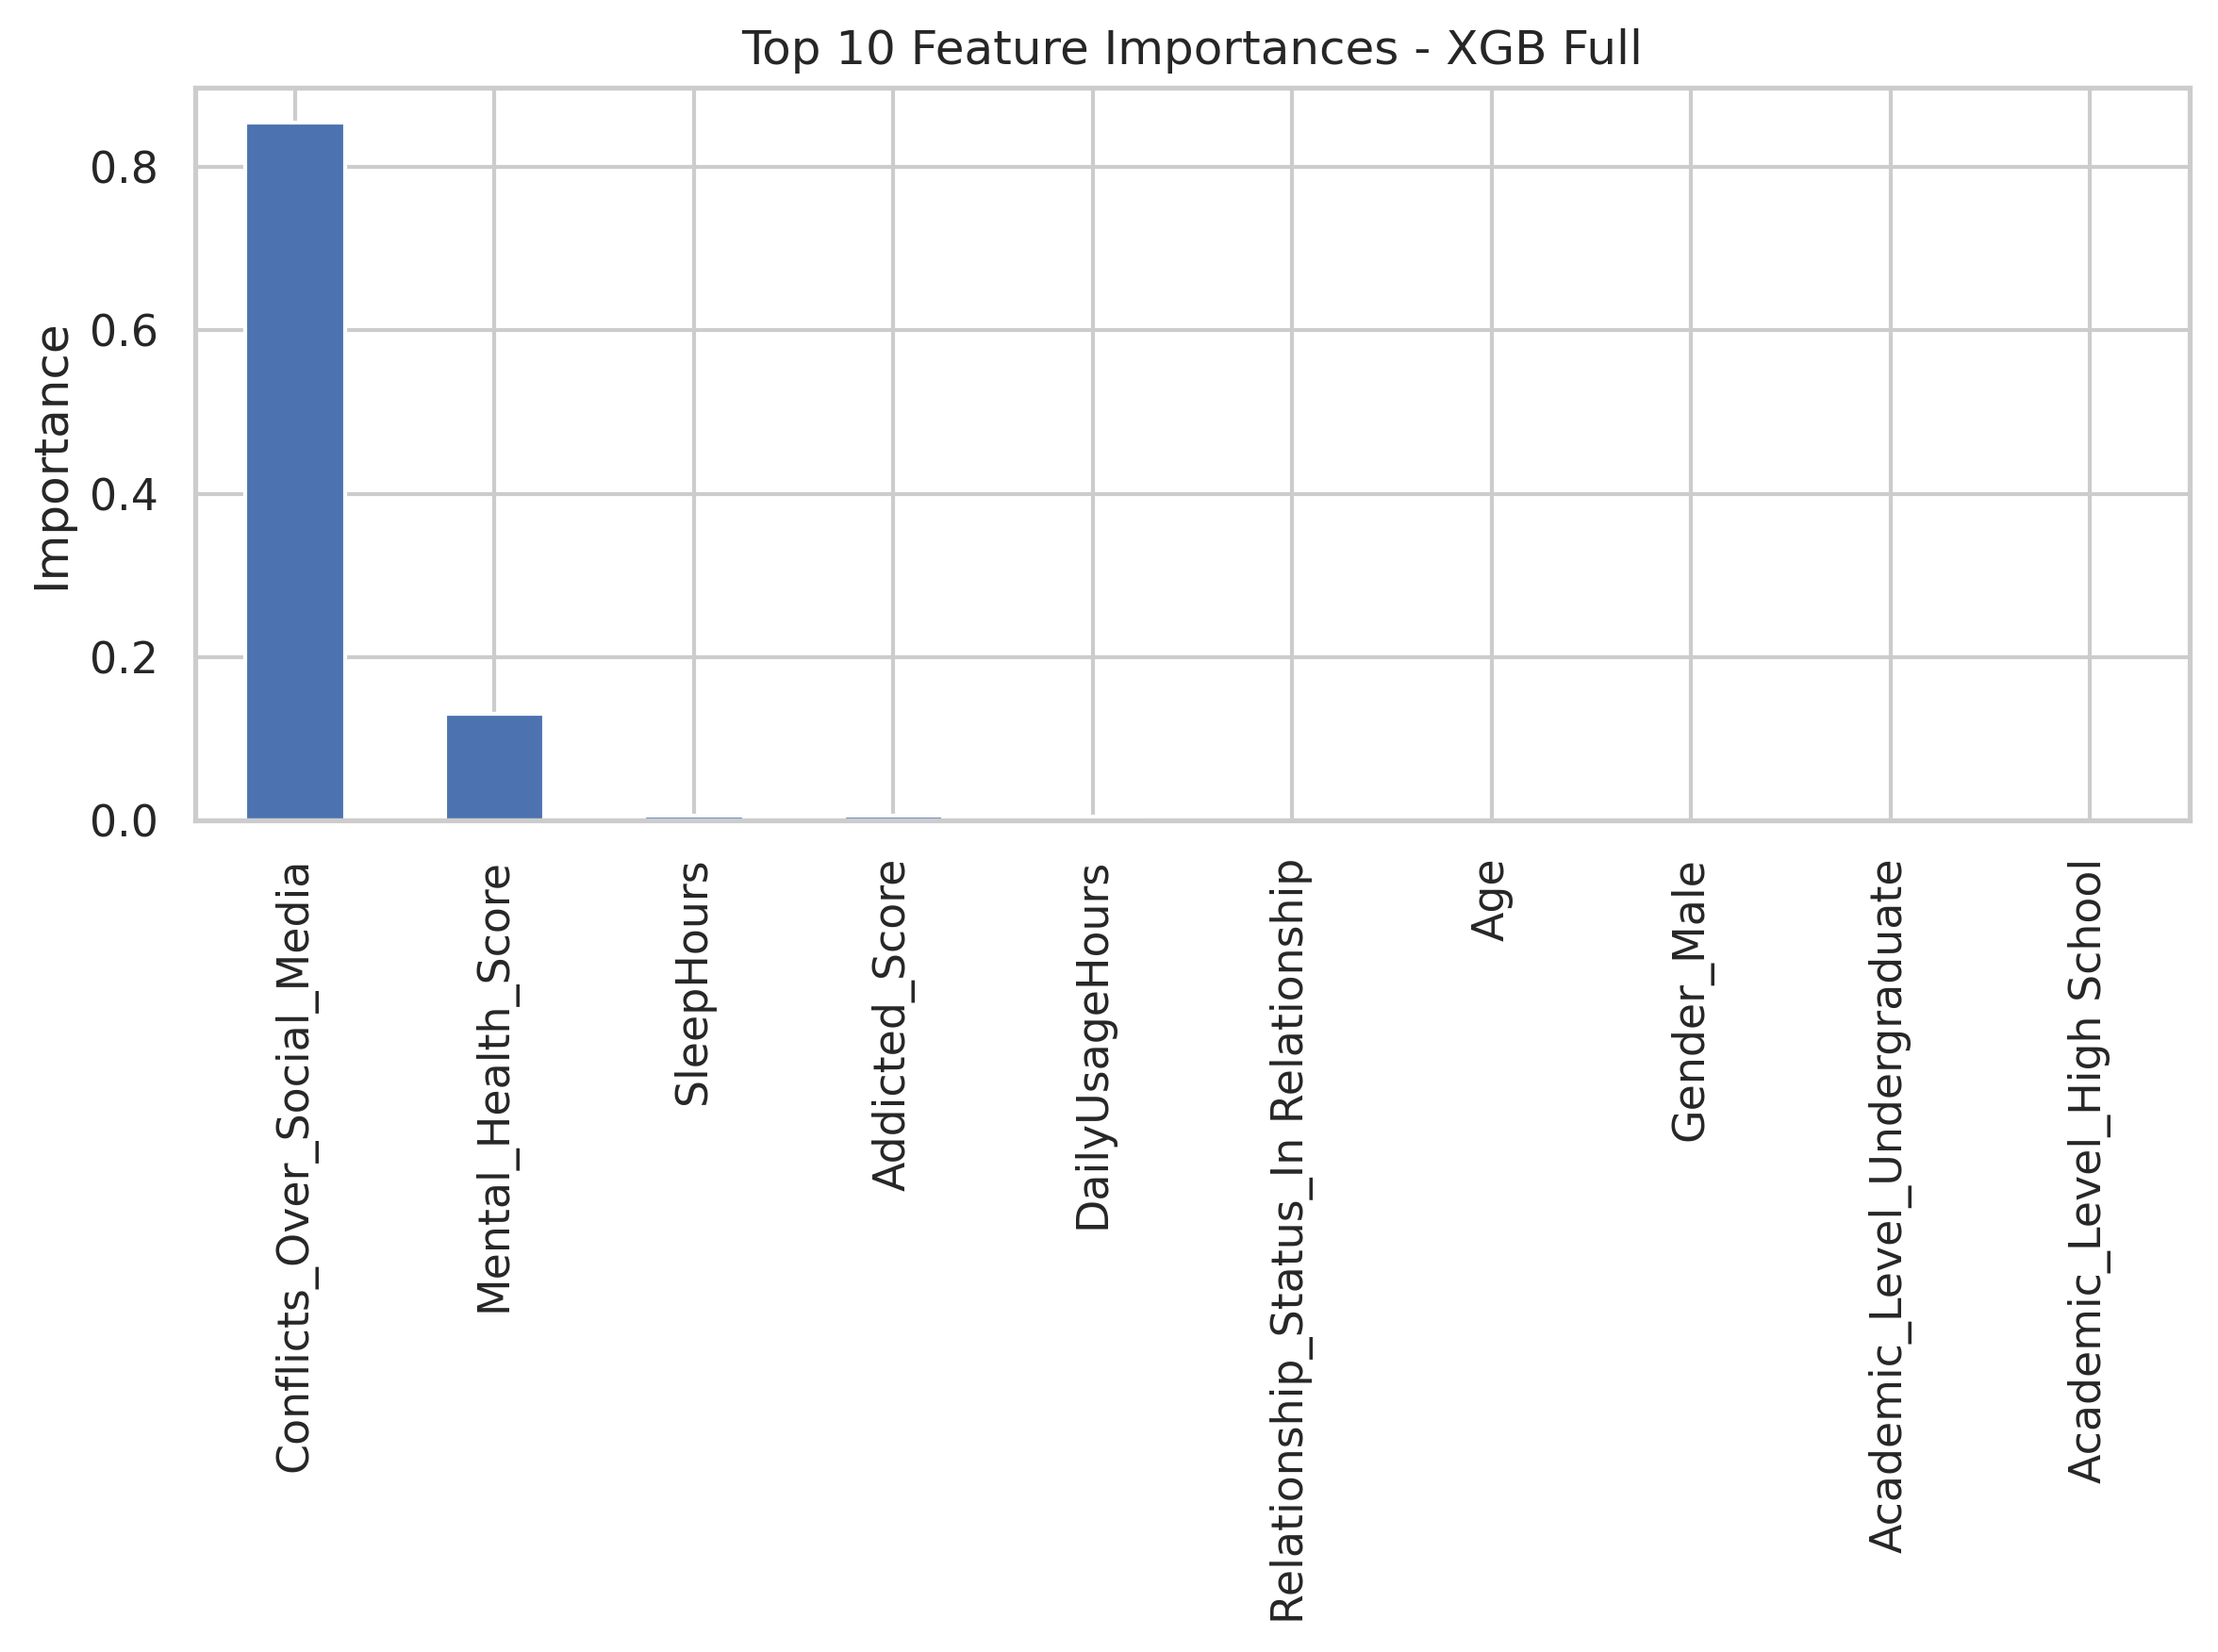

XGB No Both - XGBoost Evaluation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


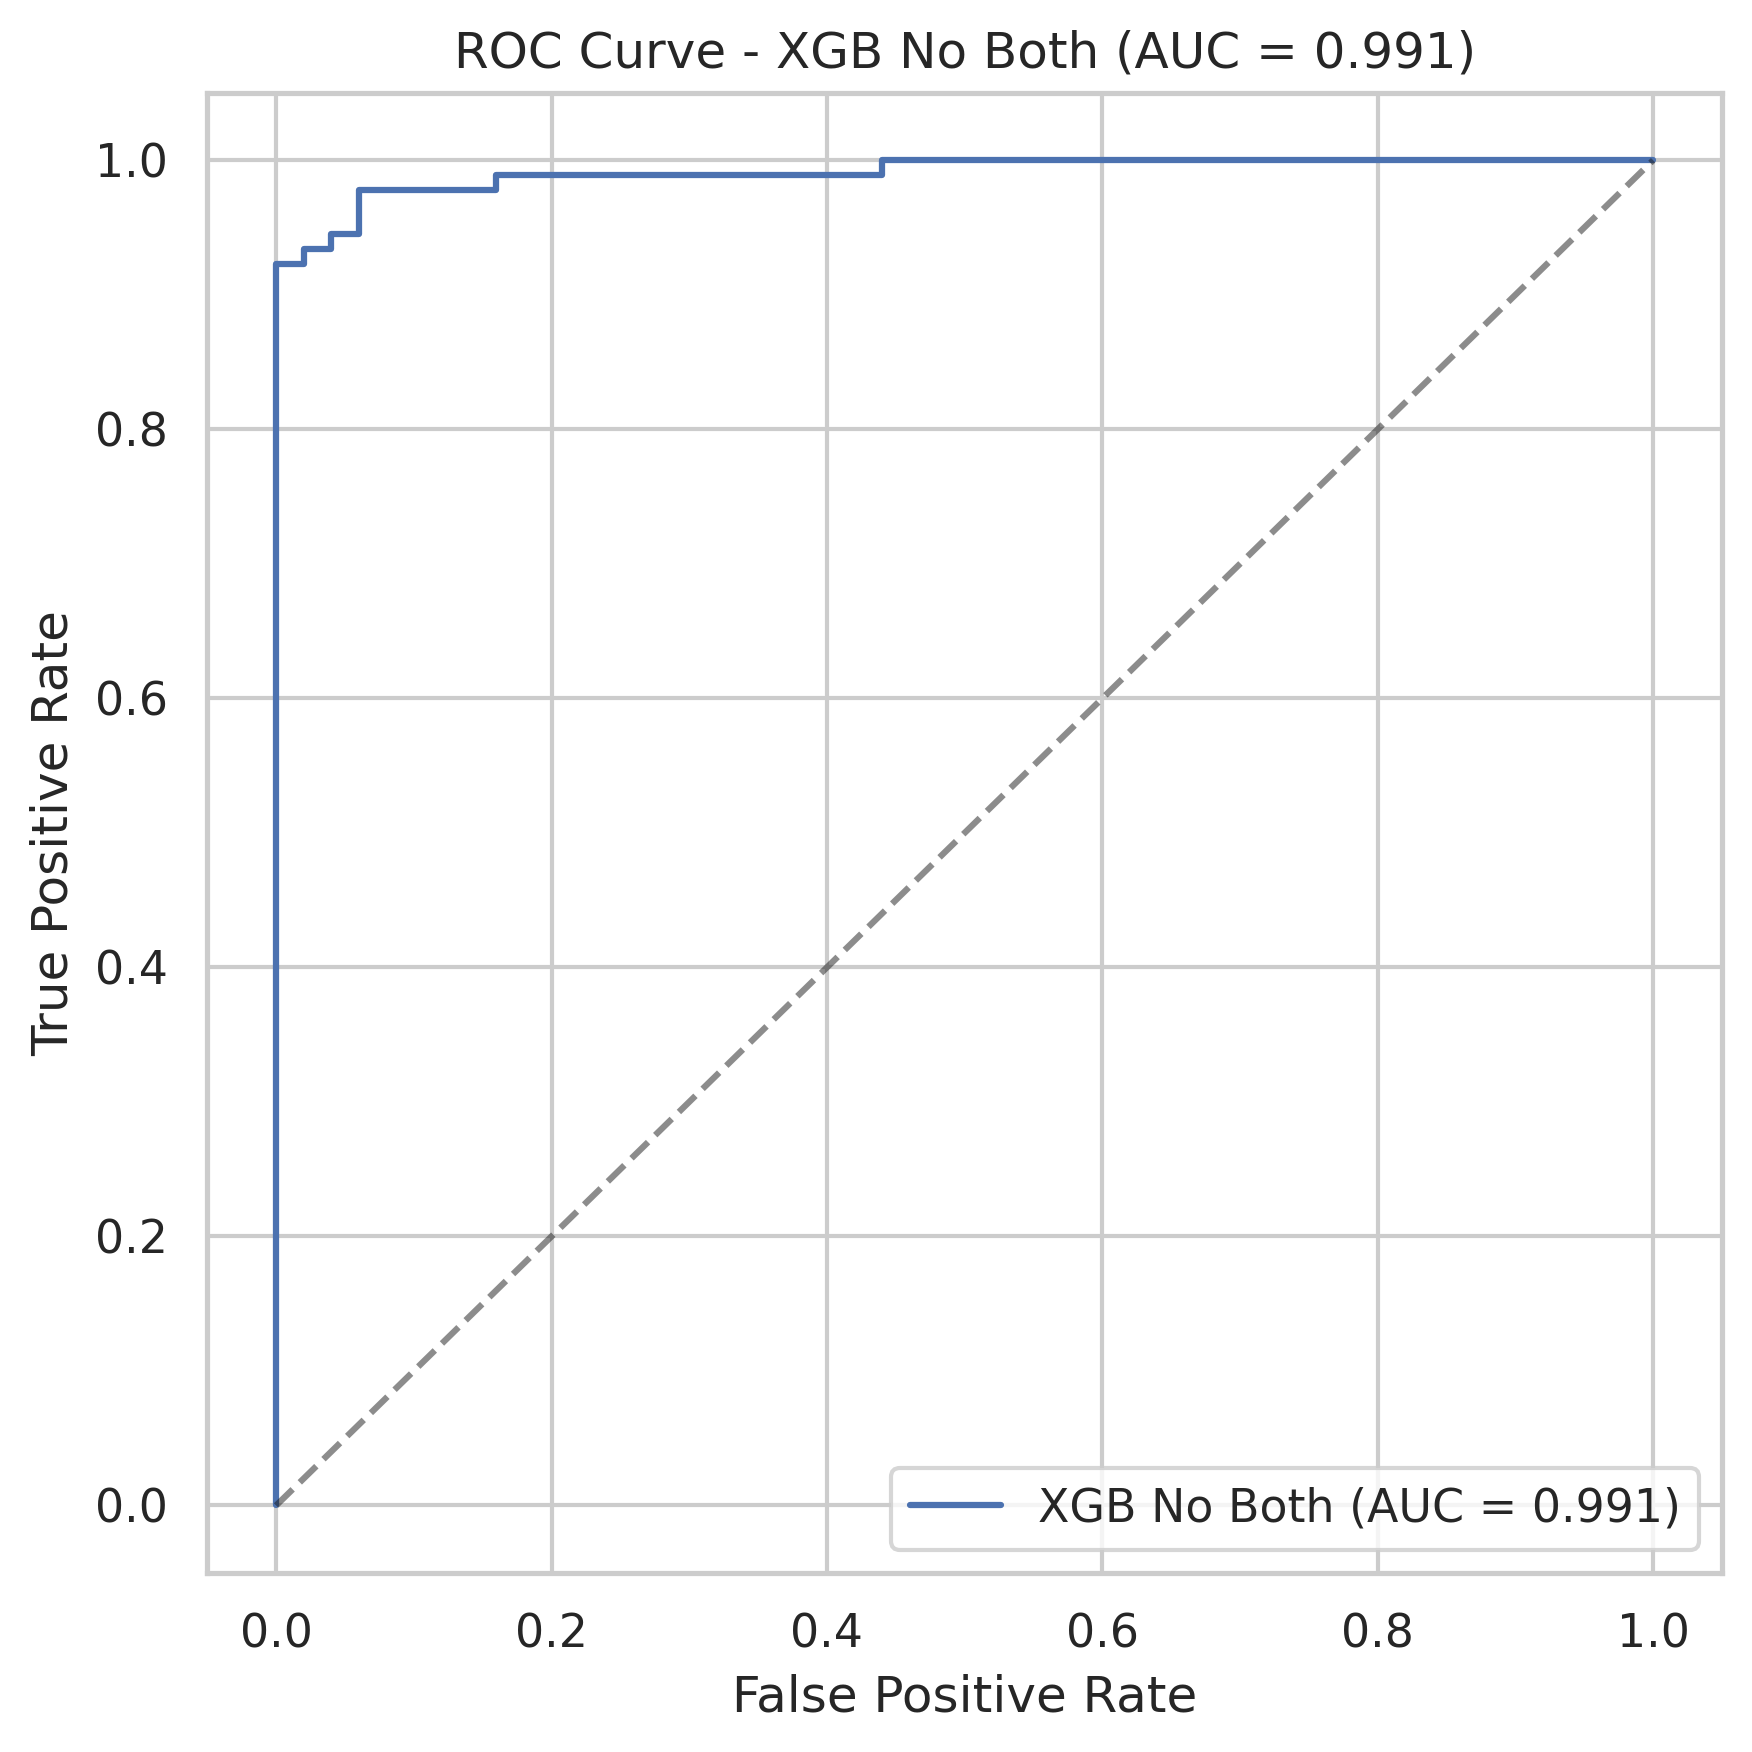

Confusion Matrix:
[[46  4]
 [ 2 89]]
              precision    recall  f1-score   support

          No       0.96      0.92      0.94        50
         Yes       0.96      0.98      0.97        91

    accuracy                           0.96       141
   macro avg       0.96      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



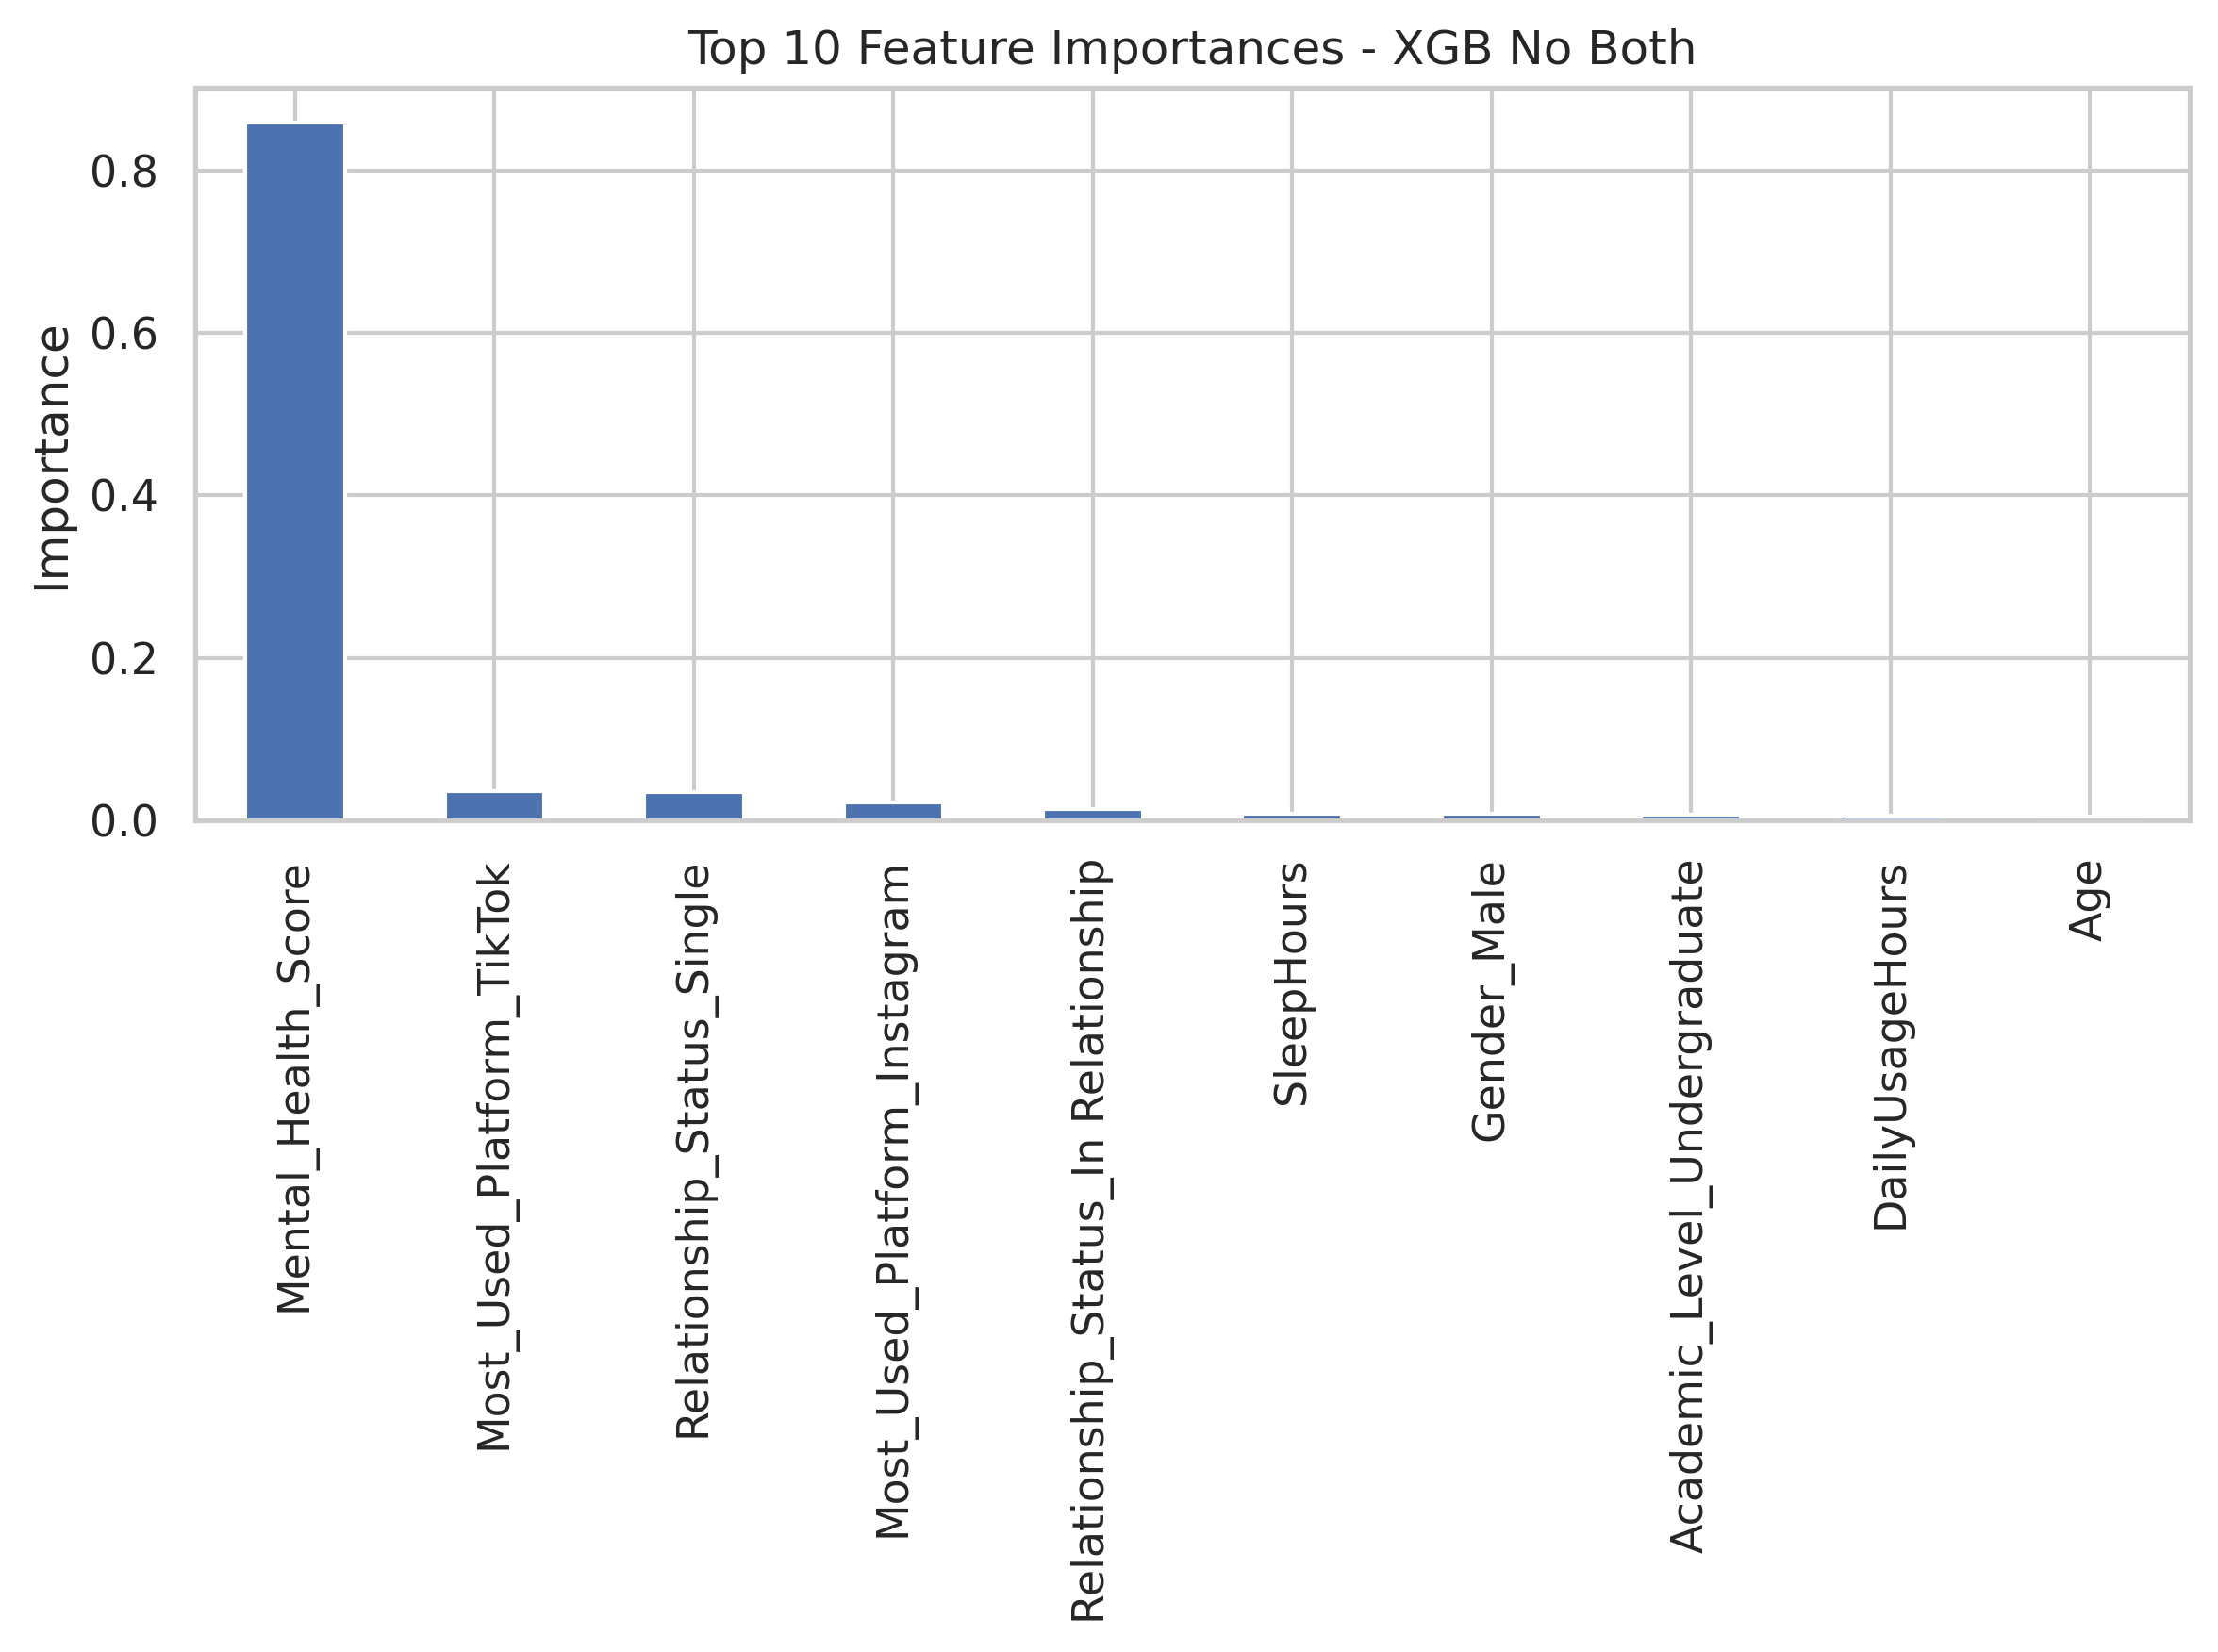

XGB Demographics Only - XGBoost Evaluation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


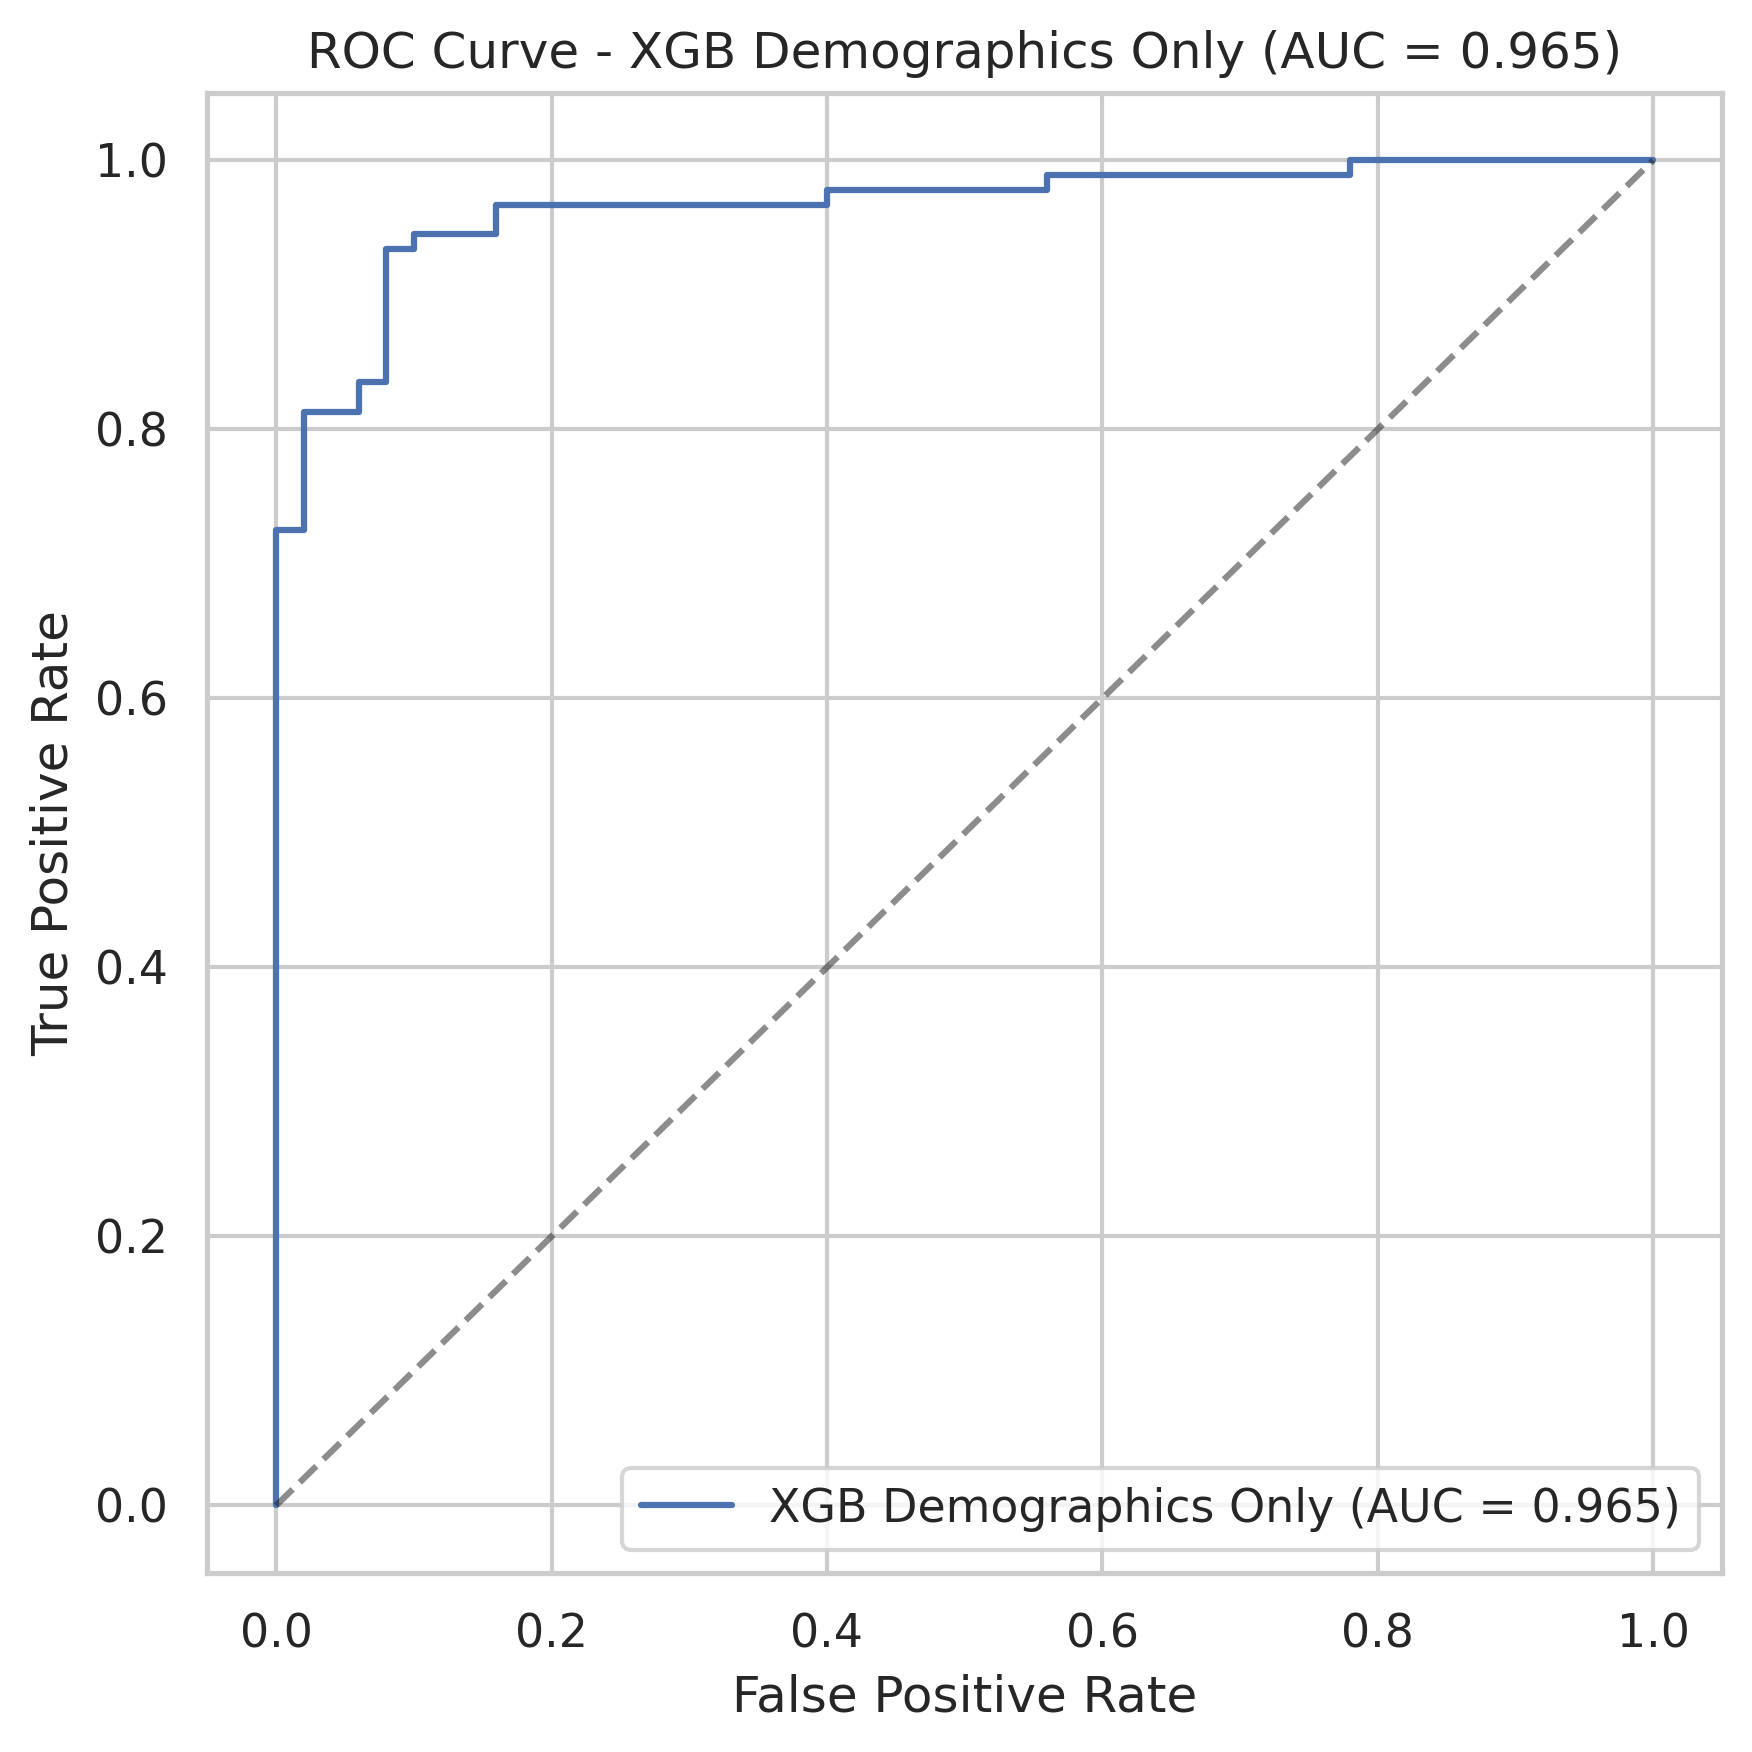

Confusion Matrix:
[[45  5]
 [ 6 85]]
              precision    recall  f1-score   support

          No       0.88      0.90      0.89        50
         Yes       0.94      0.93      0.94        91

    accuracy                           0.92       141
   macro avg       0.91      0.92      0.92       141
weighted avg       0.92      0.92      0.92       141



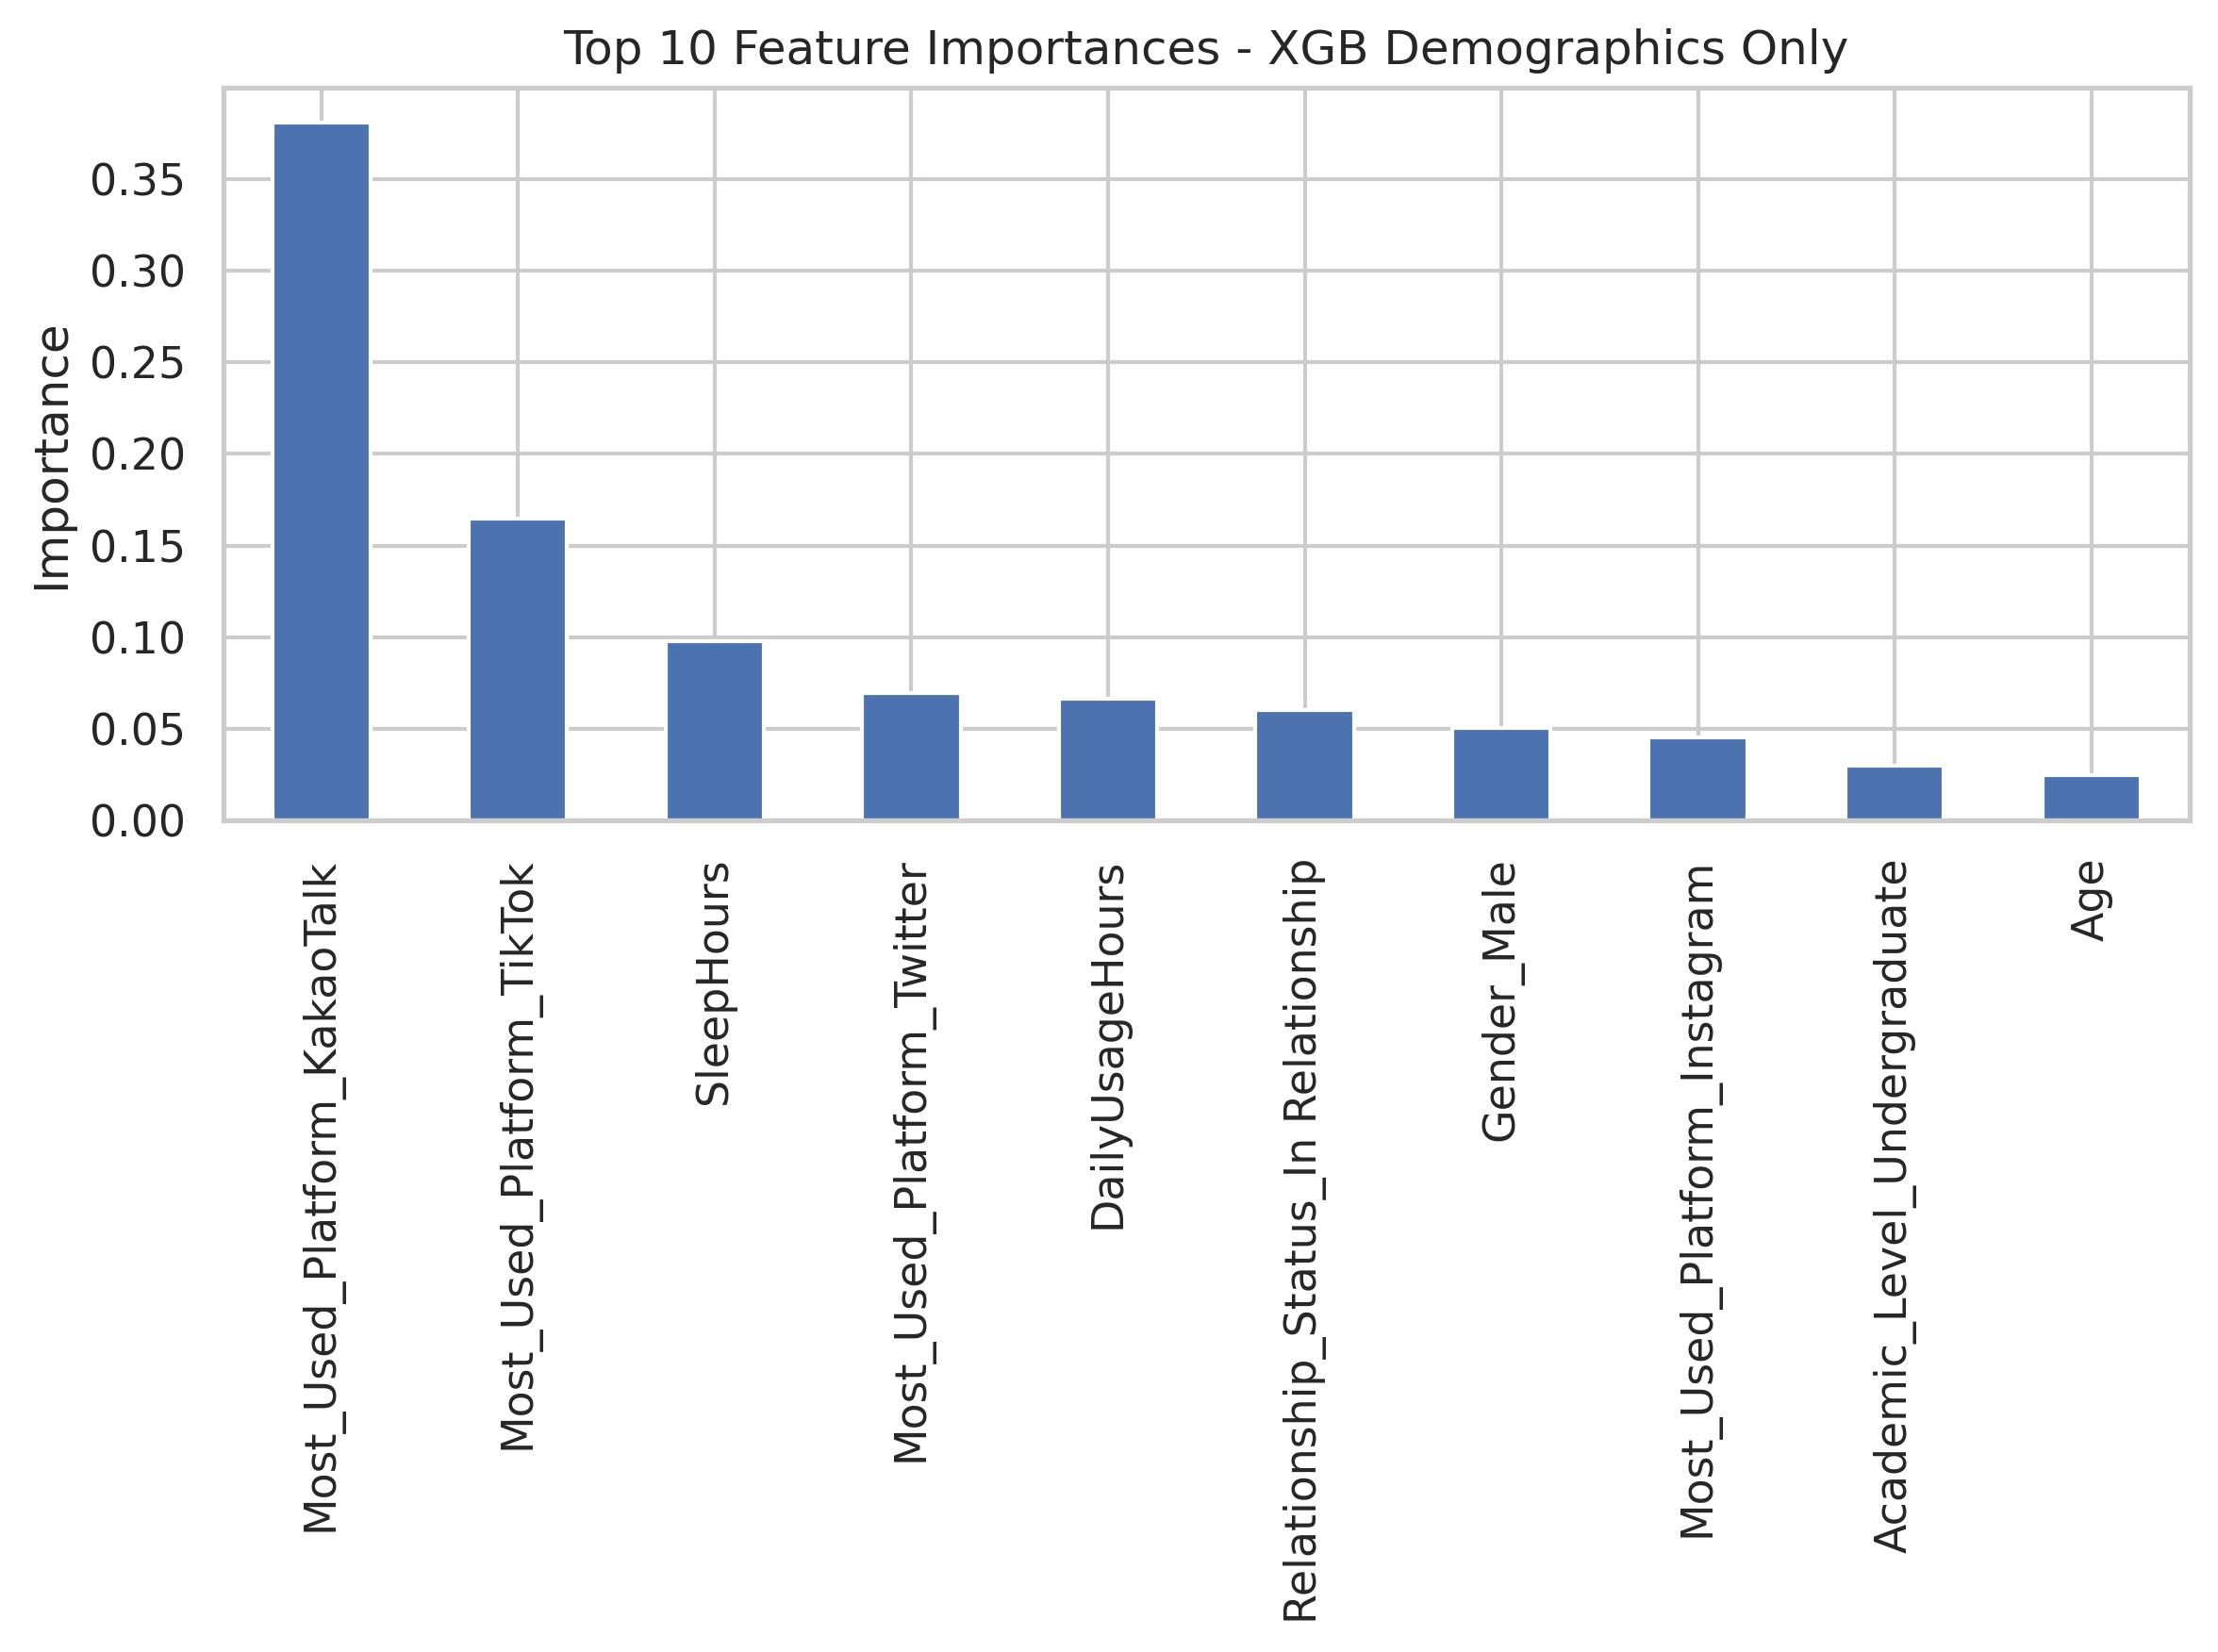

In [55]:
# Step 27: Execute XGBoost for each dataset variant

evaluate_xgb("XGB Full", X_train, y_train, X_test, y_test)
evaluate_xgb("XGB No Both", X_train_nb, y_train_nb, X_test_nb, y_test_nb)
evaluate_xgb("XGB Demographics Only", X_train_clean, y_train_clean, X_test_clean, y_test_clean)